In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from typing import Tuple, Dict

from evaluate import calculate_metrics

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [40]:
def str_to_float_list(s: str) -> np.ndarray:
    return np.array(list(map(float, s.strip('[]').split(','))))

def load_predictions_for_model(name: str, epoch: int, cfg_scale: int = None) -> Tuple[np.ndarray, np.ndarray]:
    if cfg_scale is not None:
        predictions_path = f"predictions/{name}/preds_epoch{epoch}_cfg{cfg_scale}.csv"
        print(predictions_path)
    else:
        predictions_path = f"predictions/{name}/preds_epoch{epoch}.csv"

    df = pd.read_csv(predictions_path)
    x_real = np.array([str_to_float_list(row) for row in df['x_real']])
    predictions = np.array([str_to_float_list(row) for row in df['predictions']])
    return x_real, predictions

def compute_mse(true_values: np.ndarray, predicted_values: np.ndarray) -> np.ndarray:
    return np.mean((true_values - predicted_values) ** 2, axis=1)

def plot_combined_metrics_boxplots(metrics_dict: Dict[str, Dict[str, np.ndarray]], 
                                   ylabel: str = "", 
                                   title: str = ""):
    fig, axs = plt.subplots(3, 1, figsize=(12, 16), dpi=300, sharex=False)
    plt.subplots_adjust(hspace=0.3)

    cmap = cm.get_cmap('Accent')
    labels = list(metrics_dict.keys())
    colors = [cmap(i % 10) for i in range(len(labels))]

    metric_keys = ["mse", "wasserstein", "dtw"]

    titles = {
        "mse": "Mean Squared Error",
        "wasserstein": "Wasserstein Distance",
        "dtw": "Dynamic Time Warping Distance"
    }

    xlabels = {
        "mse": "MSE",
        "wasserstein": "EM Distance",
        "dtw": "DTW Distance"
    }
    
    for ax, key in zip(axs, metric_keys):
        data = [metrics_dict[model][key] for model in labels]
        box = ax.boxplot(data, vert=False, patch_artist=True, labels=labels, widths=0.4)

        for i, (patch, color, model_name) in enumerate(zip(box['boxes'], colors, labels)):
            patch.set_facecolor(color)

        ax.set_title(titles[key], fontsize=18)
        ax.set_xlabel(xlabels[key], fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.tick_params(axis='both', labelsize=14)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def print_metric_summary(metrics_dict: Dict[str, Dict[str, np.ndarray]]) -> None:
    """
    Print mean and median for each metric and model from a metrics_dict.
    
    """
    metric_keys = ["mse", "wasserstein", "dtw"]
    metric_names = ["MSE", "Wasserstein Distance", "DTW Distance"]

    print("\n📋 Summary of Mean and Median for Each Metric:\n")
    for metric_key, metric_name in zip(metric_keys, metric_names):
        print(f"📊 {metric_name}:")
        for model_name in metrics_dict:
            values = metrics_dict[model_name][metric_key]
            mean_val = np.mean(values)
            median_val = np.median(values)
            print(f"  {model_name:<10} | Mean: {mean_val:.4f} | Median: {median_val:.4f}")
        print()


### EDM vs. DDIM

EDM
DDIM

📋 Summary of Mean and Median for Each Metric:

📊 MSE:
  EDM        | Mean: 2265.9260 | Median: 2051.3189
  DDIM       | Mean: 4606.2929 | Median: 2864.5369

📊 Wasserstein Distance:
  EDM        | Mean: 16.6679 | Median: 5.6081
  DDIM       | Mean: 24.4144 | Median: 7.6412

📊 DTW Distance:
  EDM        | Mean: 9658.3816 | Median: 9581.0276
  DDIM       | Mean: 14291.1007 | Median: 12371.8629



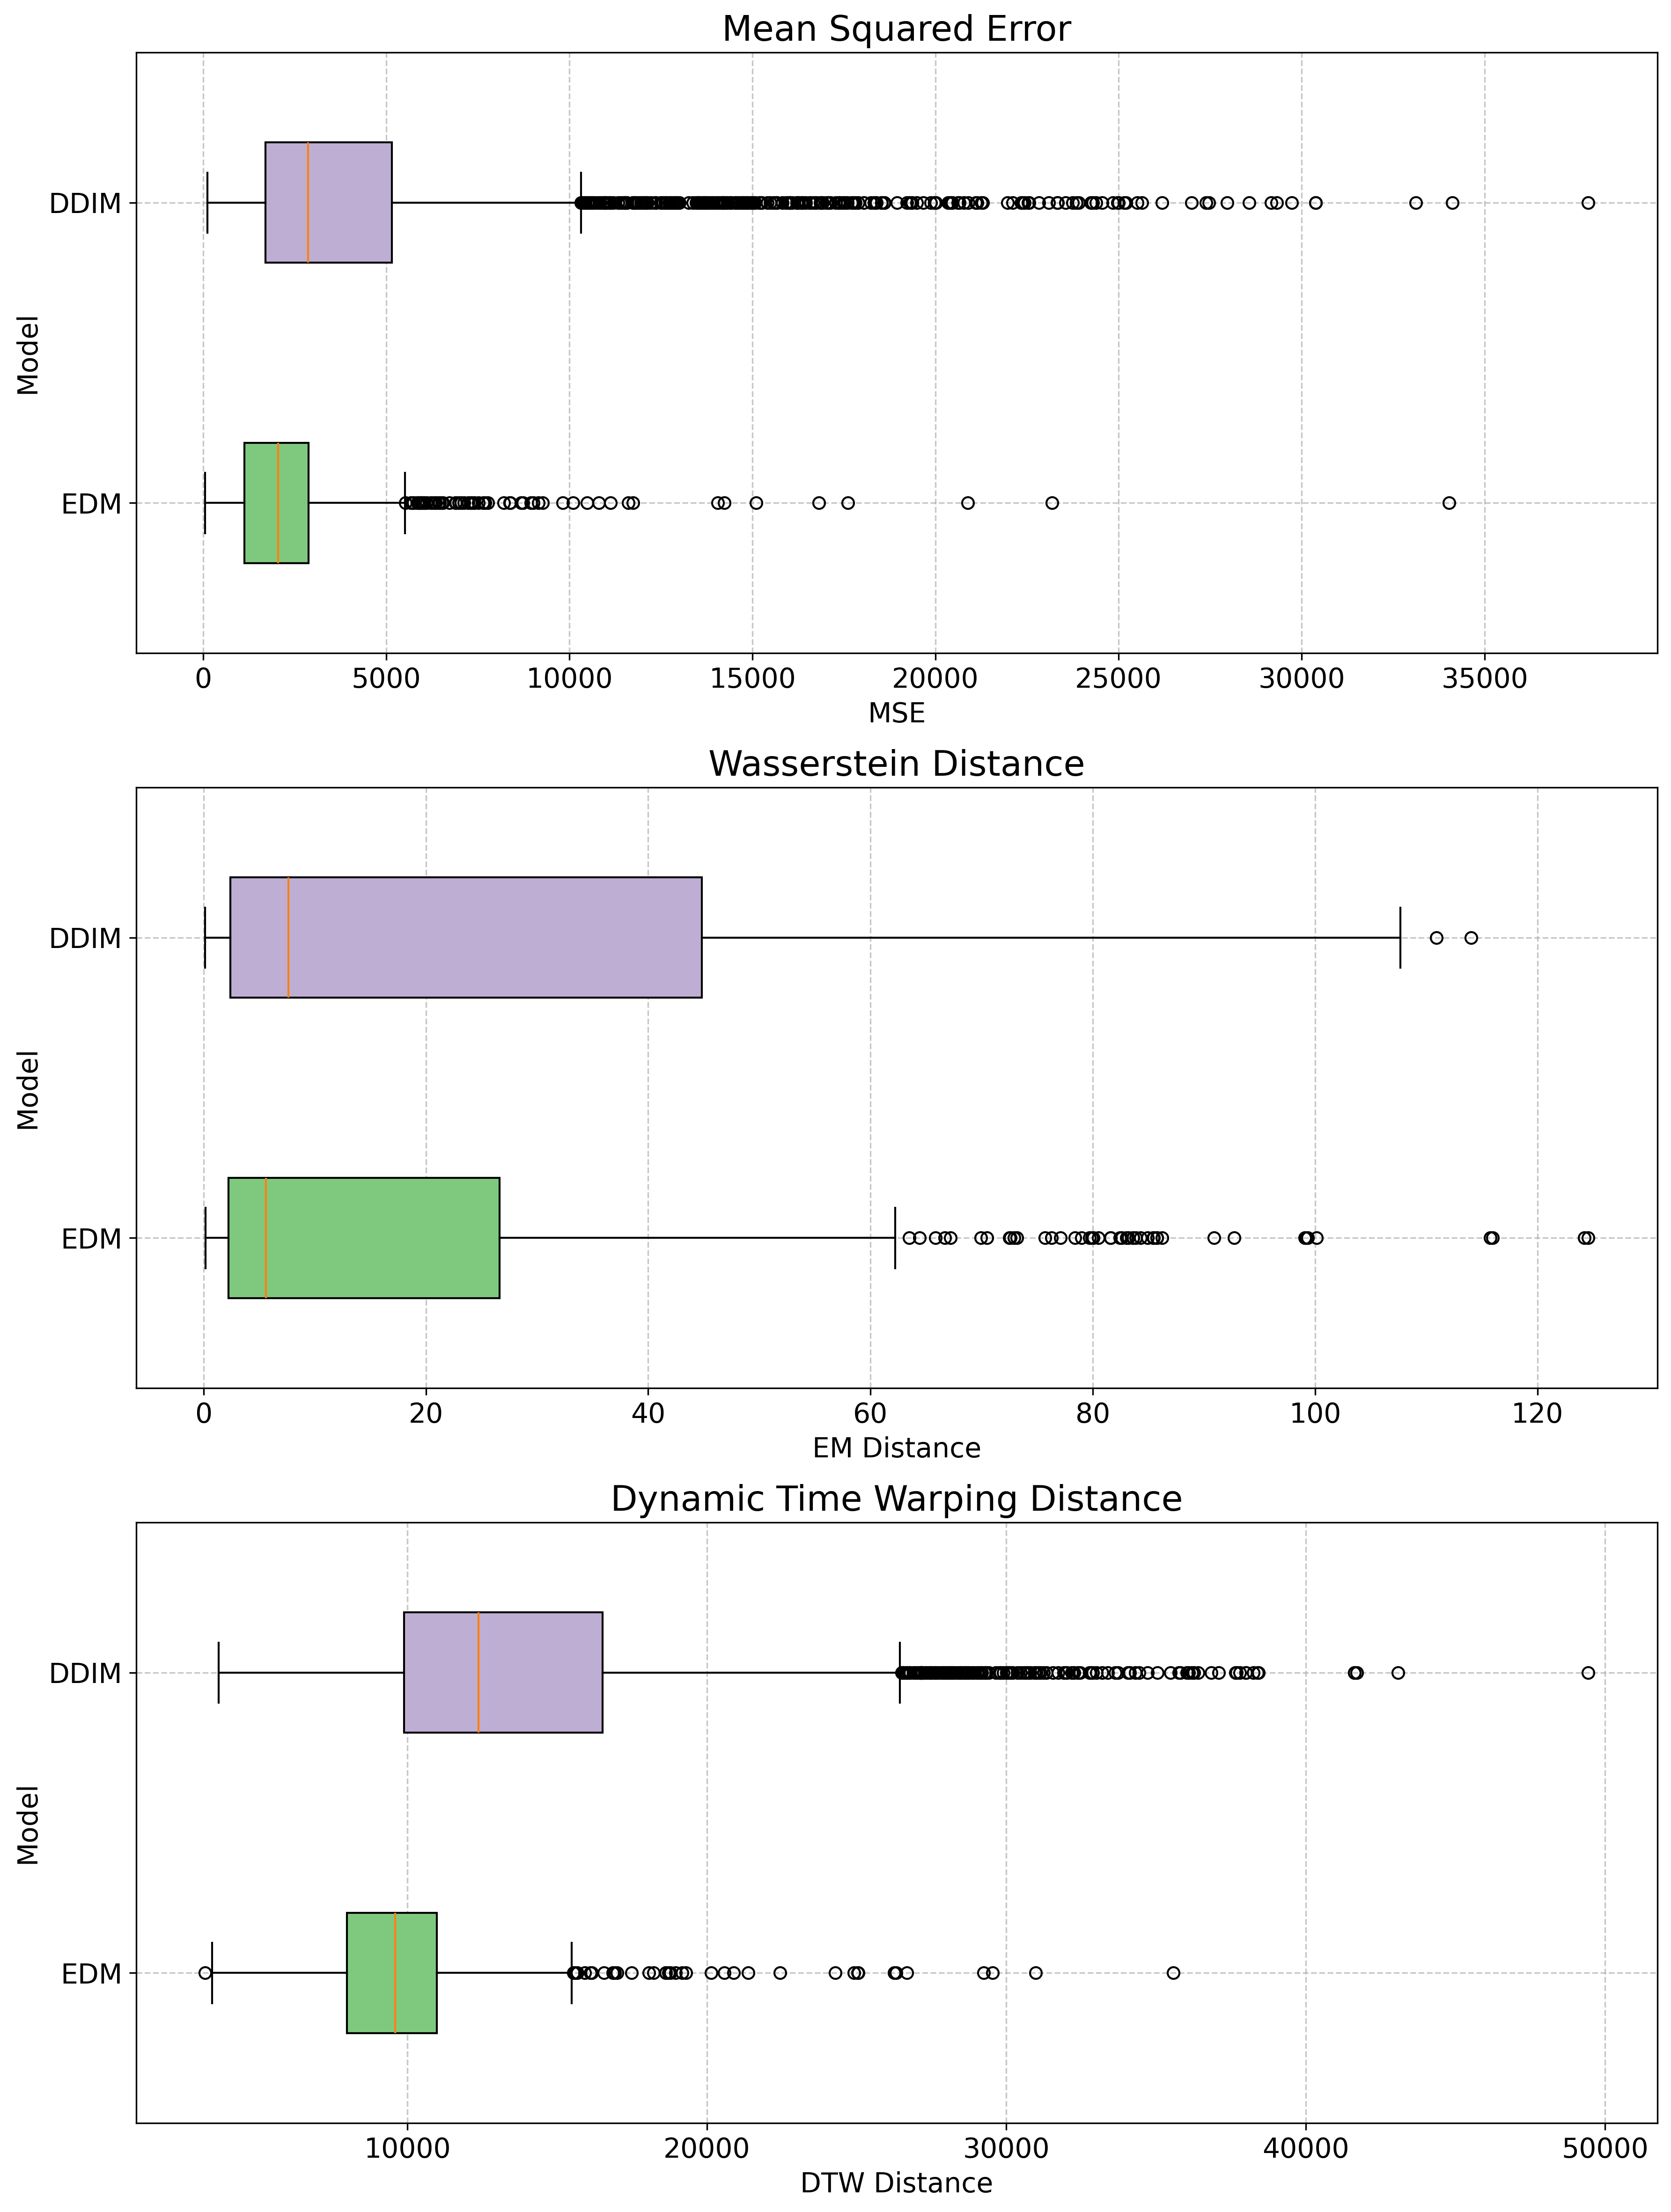

In [37]:
model_info = {
    "EDM": "predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg2.csv",
    "DDIM": "predictions/ddim_bs16_do10_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999/preds_epoch40_cfg2_sc20.csv",
    
}

epoch = 40
metrics_dict = {}

for model_name, path_name in model_info.items():
    df = pd.read_csv(path_name)
    x_real = np.array([str_to_float_list(row) for row in df['x_real']])
    predictions = np.array([str_to_float_list(row) for row in df['predictions']])
    print(model_name)
    mse, _, wasserstein, _, dtw, _ = calculate_metrics(x_real, predictions, print_results=False)

    metrics_dict[model_name] = {
        "mse": mse,
        "wasserstein": wasserstein,
        "dtw": dtw
    }

print_metric_summary(metrics_dict)

plot_combined_metrics_boxplots(metrics_dict, ylabel="Model")

## Training part

In [10]:
model_info = {
    "0 %": {"path": "edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999", "cfg_scale": 3},
    "10 %": {"path": "edm_bs16_do10_cgt20_cg3_ns30_lr1e-3_0_e40_ed999"},
    "20 %": {"path": "edm_bs16_do20_cgt20_cg3_ns30_lr1e-3_0_e40_ed999", "cfg_scale": 3},
}

epoch = 40
metrics_dict = {}

for model_display_name, model_config in model_info.items():
    path_name = model_config["path"]
    cfg_scale = model_config.get("cfg_scale", None)

    x_real, predictions = load_predictions_for_model(path_name, epoch, cfg_scale)
    print(model_display_name)
    mse, _, wasserstein, _, dtw, _ = calculate_metrics(x_real, predictions, print_results=False)

    metrics_dict[model_display_name] = {
        "mse": mse,
        "wasserstein": wasserstein,
        "dtw": dtw
    }

predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg3.csv
0 %
10 %
predictions/edm_bs16_do20_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg3.csv
20 %



📋 Summary of Mean and Median for Each Metric:

📊 MSE:
  0 %        | Mean: 2294.9403 | Median: 2083.1286
  10 %       | Mean: 2865.5356 | Median: 2282.0215
  20 %       | Mean: 2421.1037 | Median: 2076.4249

📊 Wasserstein Distance:
  0 %        | Mean: 16.6442 | Median: 5.6529
  10 %       | Mean: 18.9080 | Median: 7.2395
  20 %       | Mean: 21.1058 | Median: 7.5329

📊 DTW Distance:
  0 %        | Mean: 9664.6324 | Median: 9495.3751
  10 %       | Mean: 10584.1349 | Median: 10354.9397
  20 %       | Mean: 10746.7705 | Median: 10080.1526



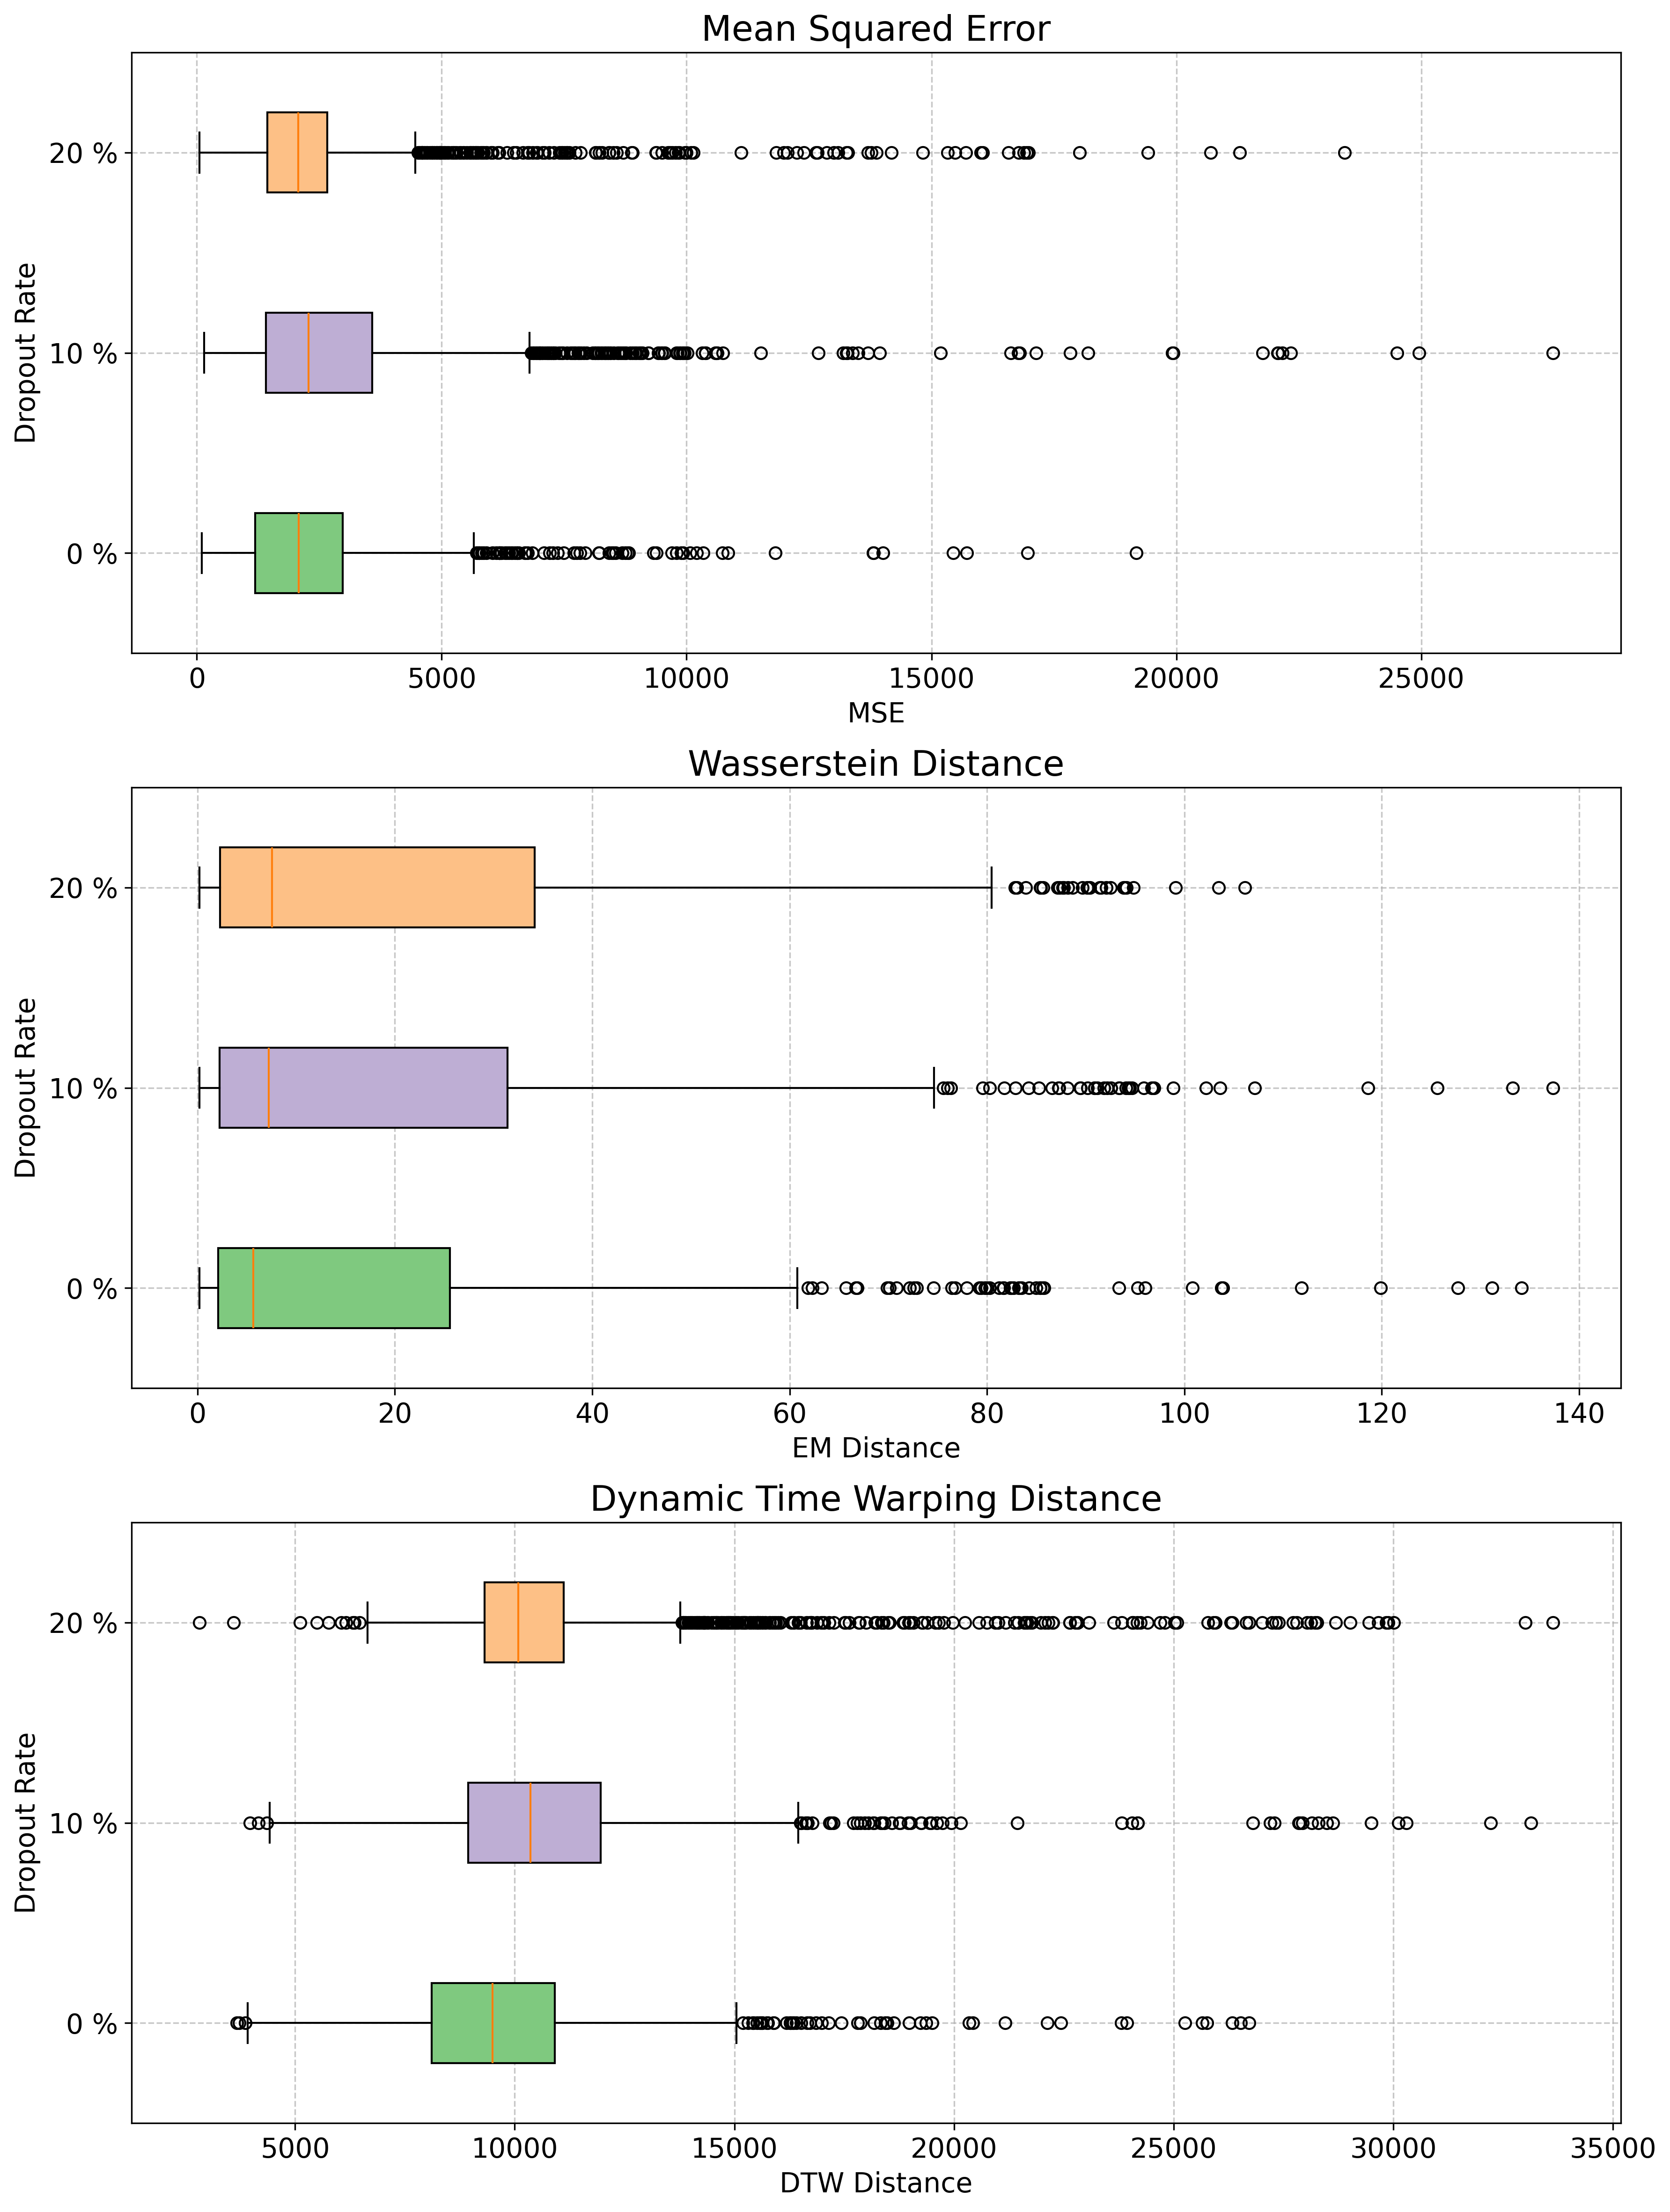

In [11]:
print_metric_summary(metrics_dict)

plot_combined_metrics_boxplots(metrics_dict, ylabel="Dropout Rate")

## Sampling part

In [23]:
model_info = {
    "no cfg": {"path": "edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999", "cfg_scale": -1},
    "0": {"path": "edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999", "cfg_scale": 0},
    "1": {"path": "edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999", "cfg_scale": 1},
    "2": {"path": "edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999", "cfg_scale": 2},
    "3": {"path": "edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999", "cfg_scale": 3},
    "4": {"path": "edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999", "cfg_scale": 4},
    "5": {"path": "edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999", "cfg_scale": 5},
    "6": {"path": "edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999", "cfg_scale": 6},
    "7": {"path": "edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999", "cfg_scale": 7},
    "8": {"path": "edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999", "cfg_scale": 8},
    "9": {"path": "edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999", "cfg_scale": 9},
    "10": {"path": "edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999", "cfg_scale": 10},
}

epoch = 40
metrics_dict = {}

for model_display_name, model_config in model_info.items():
    path_name = model_config["path"]
    cfg_scale = model_config.get("cfg_scale", None)

    x_real, predictions = load_predictions_for_model(path_name, epoch, cfg_scale)
    print(model_display_name)
    mse, _, wasserstein, _, dtw, _ = calculate_metrics(x_real, predictions, print_results=False)

    metrics_dict[model_display_name] = {
        "mse": mse,
        "wasserstein": wasserstein,
        "dtw": dtw
    }

predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg-1.csv
no cfg
predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg0.csv
0
predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg1.csv
1
predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg2.csv
2
predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg3.csv
3
predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg4.csv
4
predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg5.csv
5
predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg6.csv
6
predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg7.csv
7
predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg8.csv
8
predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg9.csv
9
predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch


📋 Summary of Mean and Median for Each Metric:

📊 MSE:
  no cfg     | Mean: 2424.1911 | Median: 2075.4048
  0          | Mean: 16313.1387 | Median: 6464.2808
  1          | Mean: 2380.7915 | Median: 2002.4582
  2          | Mean: 2265.9260 | Median: 2051.3189
  3          | Mean: 2294.9403 | Median: 2083.1286
  4          | Mean: 2388.4084 | Median: 2151.9673
  5          | Mean: 2424.6314 | Median: 2244.8993
  6          | Mean: 2514.2190 | Median: 2296.2376
  7          | Mean: 2609.9547 | Median: 2363.0304
  8          | Mean: 2734.8233 | Median: 2445.2183
  9          | Mean: 2816.3782 | Median: 2548.0669
  10         | Mean: 2980.2397 | Median: 2629.1453

📊 Wasserstein Distance:
  no cfg     | Mean: 16.9337 | Median: 5.6158
  0          | Mean: 39.6384 | Median: 7.4259
  1          | Mean: 16.7711 | Median: 5.6946
  2          | Mean: 16.6679 | Median: 5.6081
  3          | Mean: 16.6442 | Median: 5.6529
  4          | Mean: 16.7259 | Median: 5.6448
  5          | Mean: 16.6963 | 

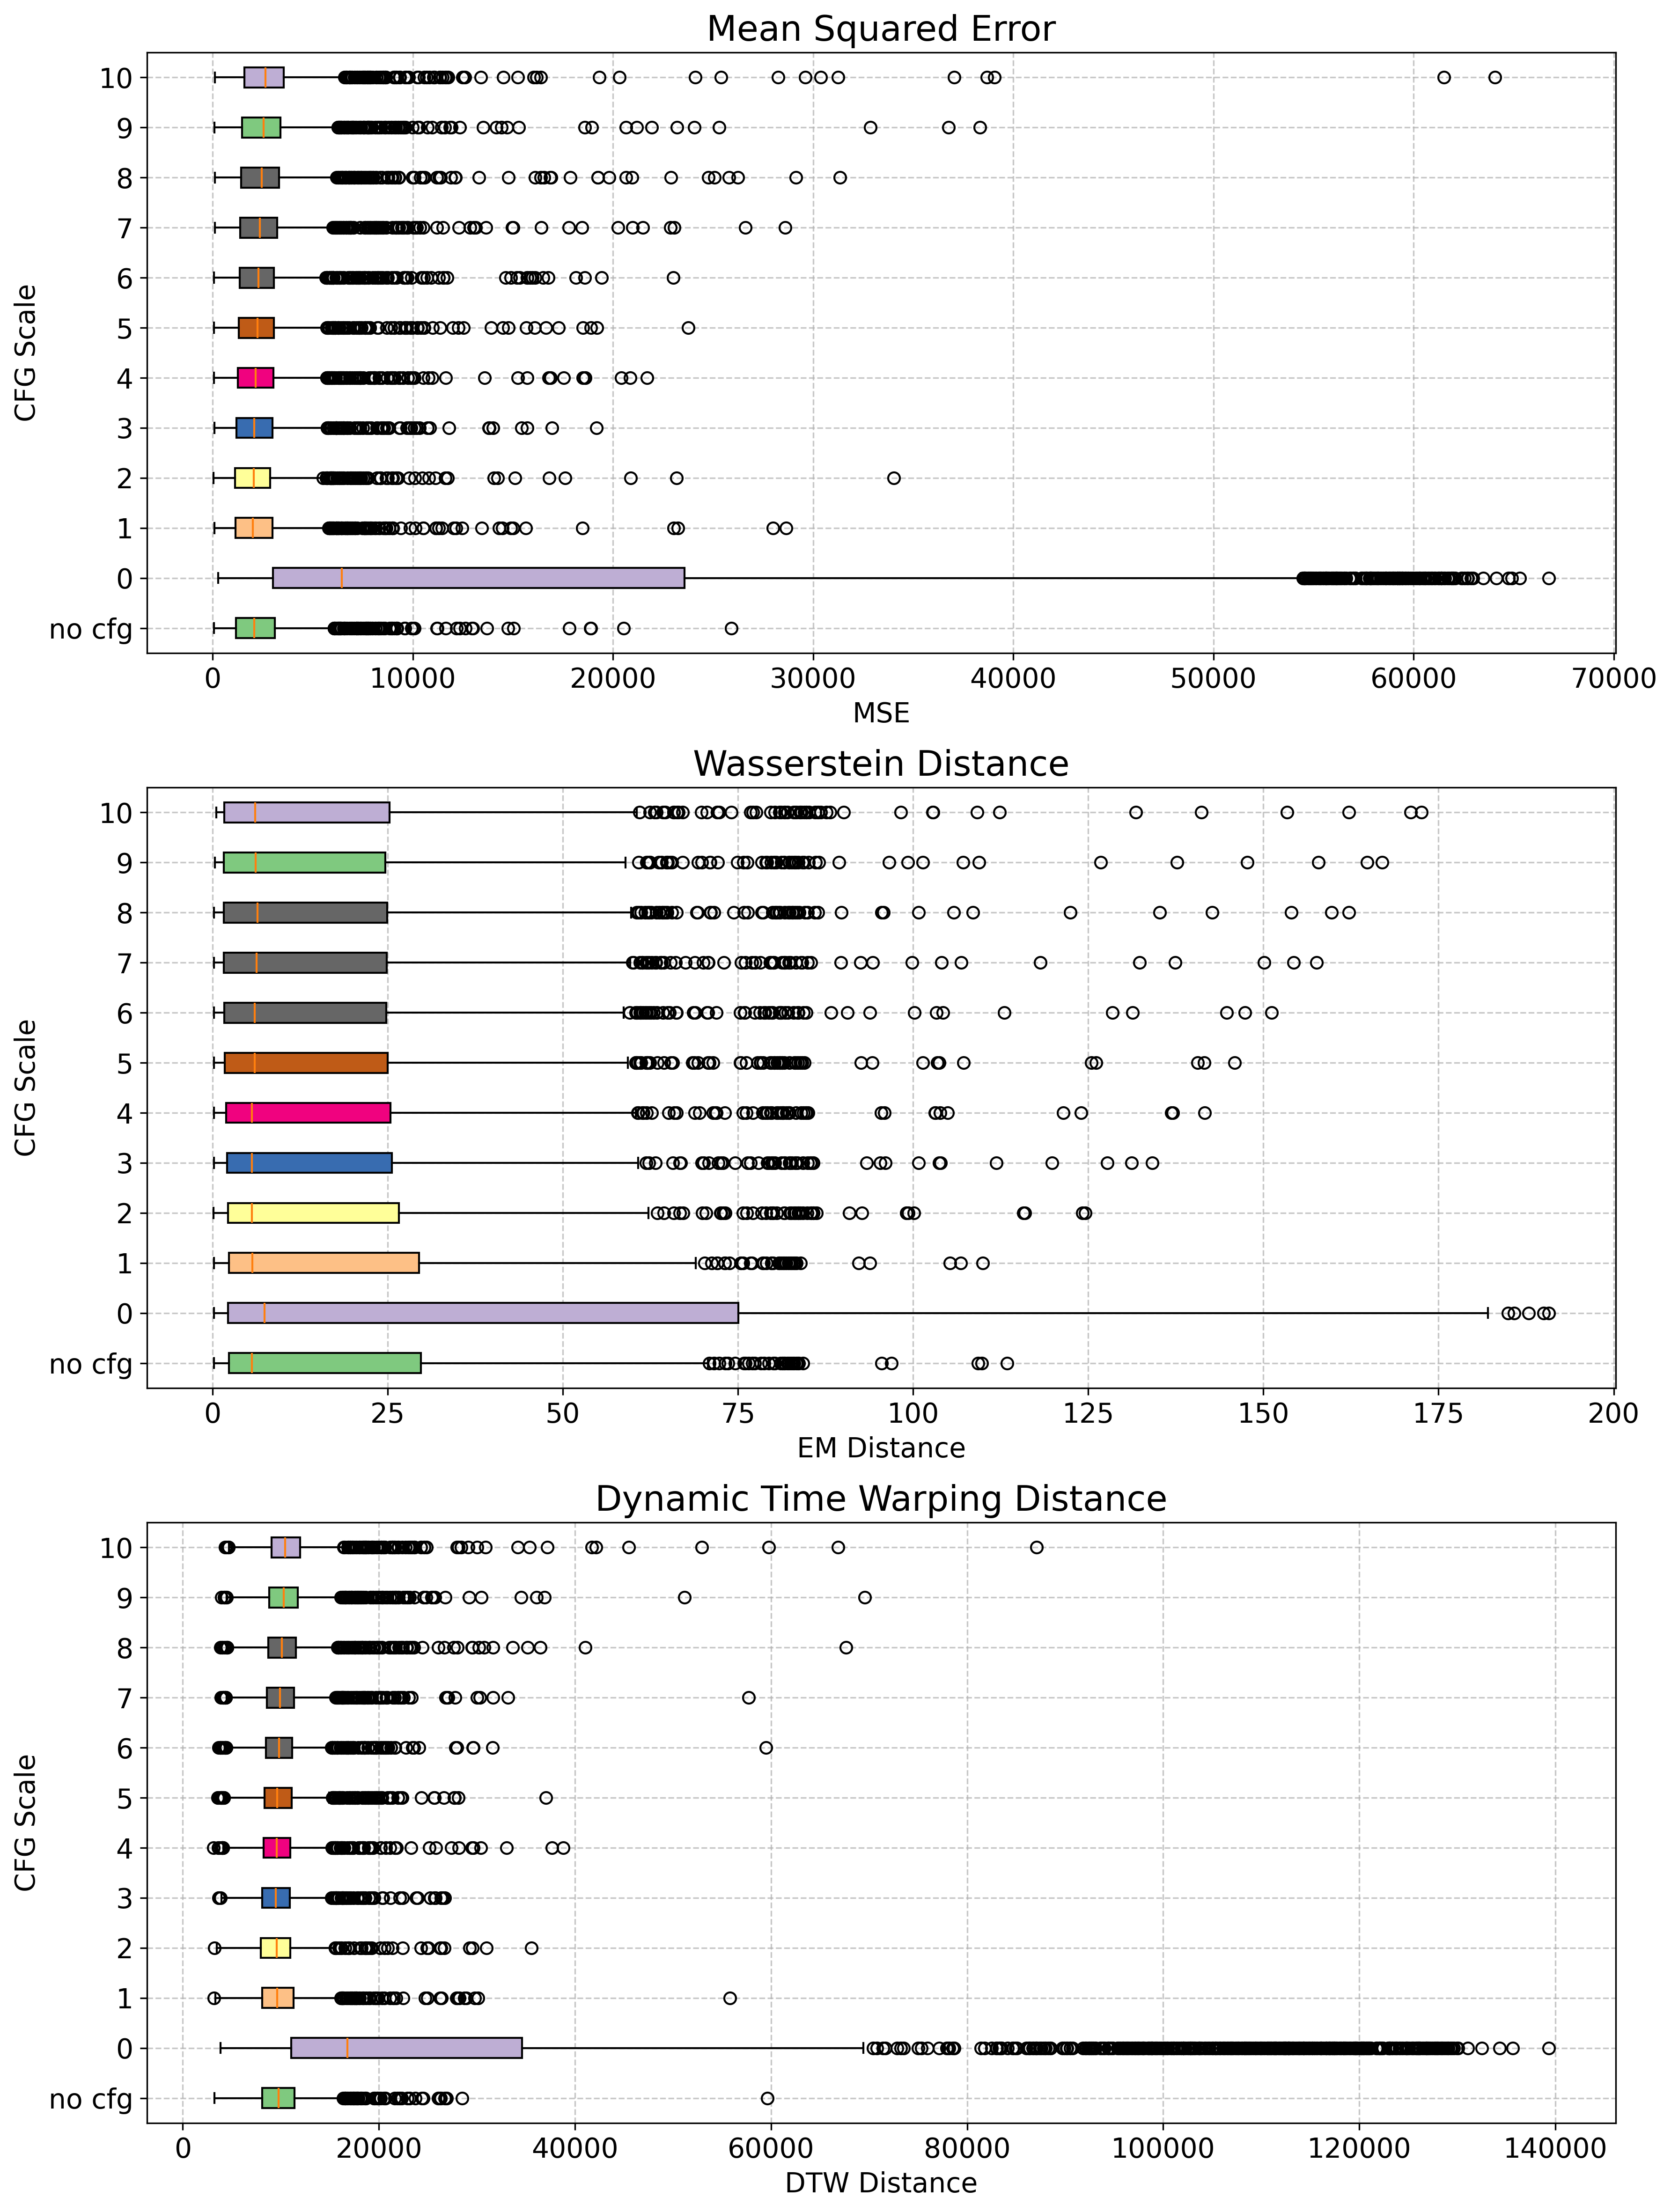

In [24]:
print_metric_summary(metrics_dict)

plot_combined_metrics_boxplots(metrics_dict, ylabel="CFG Scale")

In [25]:
metrics_dict_short = {}
metrics_dict_short['no cfg'] = metrics_dict['no cfg']
metrics_dict_short['1'] = metrics_dict['1']
metrics_dict_short['2'] = metrics_dict['2']
metrics_dict_short['3'] = metrics_dict['3']
metrics_dict_short['4'] = metrics_dict['4']


📋 Summary of Mean and Median for Each Metric:

📊 MSE:
  no cfg     | Mean: 2424.1911 | Median: 2075.4048
  1          | Mean: 2380.7915 | Median: 2002.4582
  2          | Mean: 2265.9260 | Median: 2051.3189
  3          | Mean: 2294.9403 | Median: 2083.1286
  4          | Mean: 2388.4084 | Median: 2151.9673

📊 Wasserstein Distance:
  no cfg     | Mean: 16.9337 | Median: 5.6158
  1          | Mean: 16.7711 | Median: 5.6946
  2          | Mean: 16.6679 | Median: 5.6081
  3          | Mean: 16.6442 | Median: 5.6529
  4          | Mean: 16.7259 | Median: 5.6448

📊 DTW Distance:
  no cfg     | Mean: 10052.2594 | Median: 9754.4234
  1          | Mean: 9958.7954 | Median: 9650.1530
  2          | Mean: 9658.3816 | Median: 9581.0276
  3          | Mean: 9664.6324 | Median: 9495.3751
  4          | Mean: 9806.6700 | Median: 9592.6314



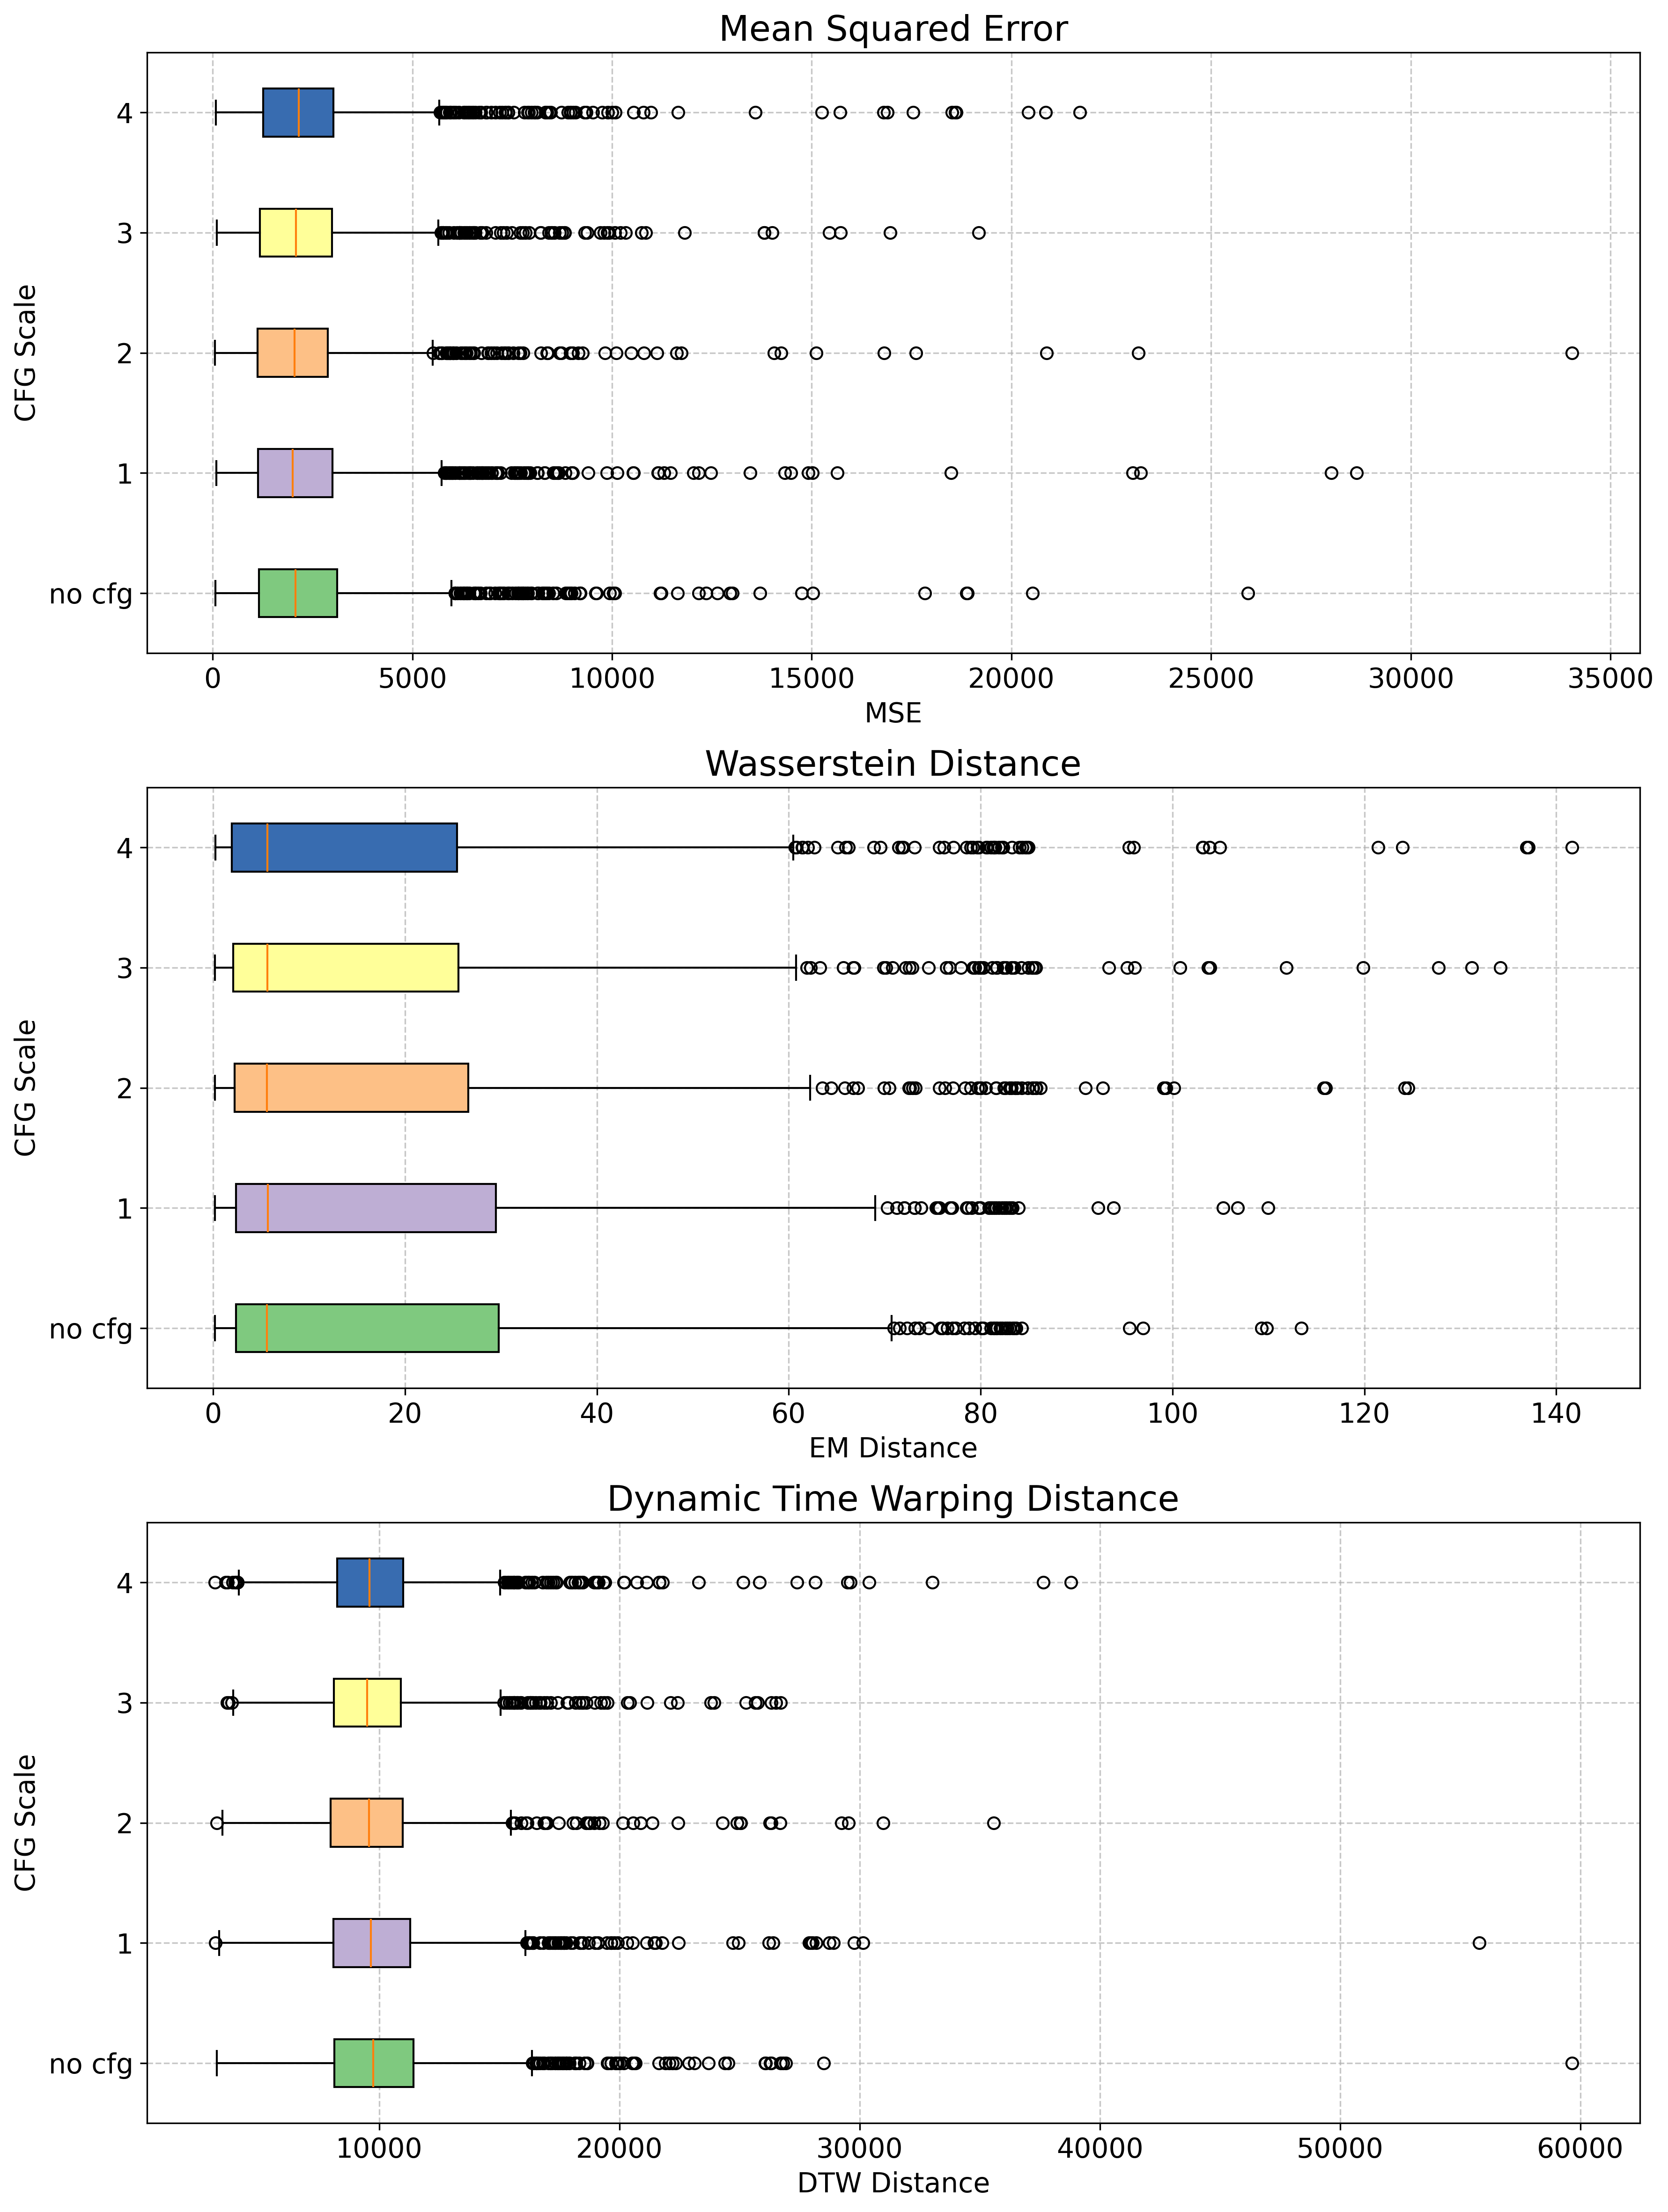

In [26]:
print_metric_summary(metrics_dict_short)

plot_combined_metrics_boxplots(metrics_dict_short, ylabel="CFG Scale")

In [27]:
metrics_dict_short = {}
metrics_dict_short['1'] = metrics_dict['1']
metrics_dict_short['2'] = metrics_dict['2']
metrics_dict_short['3'] = metrics_dict['3']
metrics_dict_short['4'] = metrics_dict['4']


📋 Summary of Mean and Median for Each Metric:

📊 MSE:
  1          | Mean: 2380.7915 | Median: 2002.4582
  2          | Mean: 2265.9260 | Median: 2051.3189
  3          | Mean: 2294.9403 | Median: 2083.1286
  4          | Mean: 2388.4084 | Median: 2151.9673

📊 Wasserstein Distance:
  1          | Mean: 16.7711 | Median: 5.6946
  2          | Mean: 16.6679 | Median: 5.6081
  3          | Mean: 16.6442 | Median: 5.6529
  4          | Mean: 16.7259 | Median: 5.6448

📊 DTW Distance:
  1          | Mean: 9958.7954 | Median: 9650.1530
  2          | Mean: 9658.3816 | Median: 9581.0276
  3          | Mean: 9664.6324 | Median: 9495.3751
  4          | Mean: 9806.6700 | Median: 9592.6314



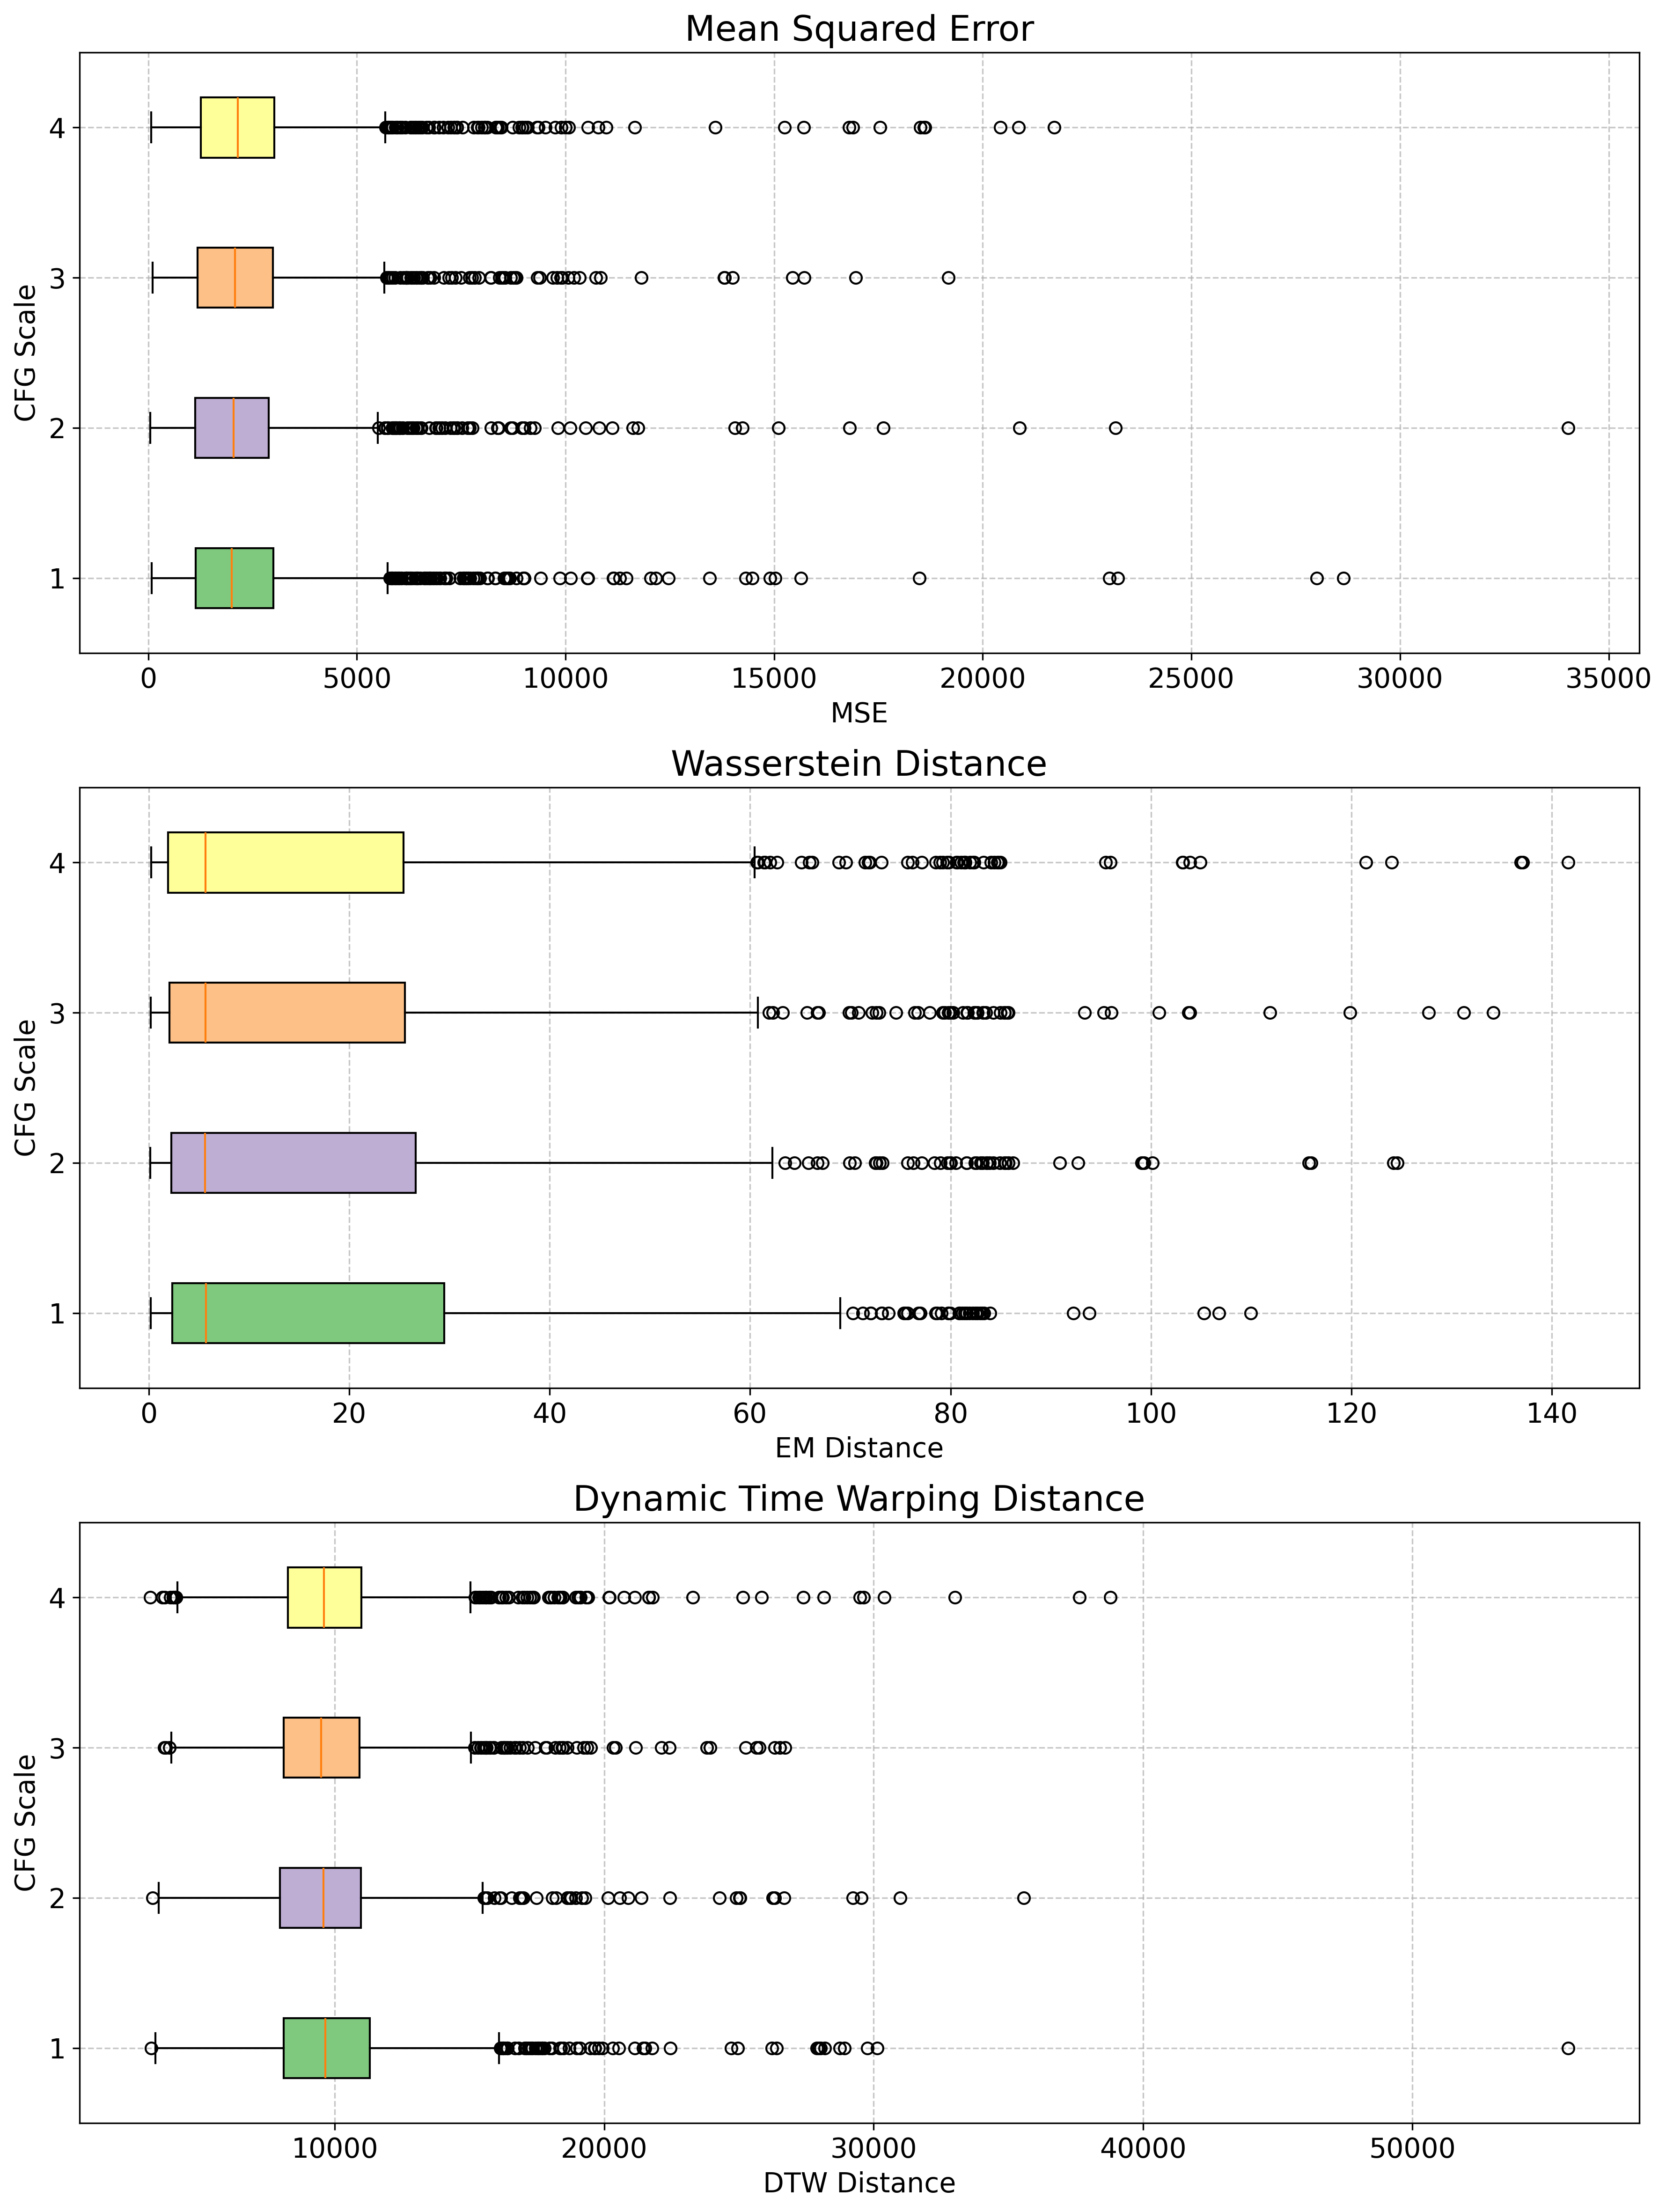

In [28]:
print_metric_summary(metrics_dict_short)

plot_combined_metrics_boxplots(metrics_dict_short, ylabel="CFG Scale")

#### Adaptive CFG scale

In [39]:
model_info = {
    "cfg4 a=2, b=4": "predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg4_betaCFG_a2b4_noNorm.csv",
    "cfg3 a=2, b=4": "predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg3_betaCFG_a2b4_noNorm.csv",
    "cfg2 a=2, b=4": "predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg2_betaCFG_a2b4_noNorm.csv",
    
    "cfg4 a=2, b=2": "predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg4_betaCFG_noNorm.csv",
    "cfg3 a=2, b=2": "predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg3_betaCFG_noNorm.csv",
    "cfg2 a=2, b=2": "predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg2_betaCFG_noNorm.csv",
}

epoch = 40
metrics_dict = {}

for model_name, path_name in model_info.items():
    df = pd.read_csv(path_name)
    x_real = np.array([str_to_float_list(row) for row in df['x_real']])
    predictions = np.array([str_to_float_list(row) for row in df['predictions']])
    print(model_name)
    mse, _, wasserstein, _, dtw, _ = calculate_metrics(x_real, predictions, print_results=False)

    metrics_dict[model_name] = {
        "mse": mse,
        "wasserstein": wasserstein,
        "dtw": dtw
    }

cfg4 a=2, b=4
cfg3 a=2, b=4
cfg2 a=2, b=4
cfg4 a=2, b=2
cfg3 a=2, b=2
cfg2 a=2, b=2


In [44]:
print_metric_summary(metrics_dict)


📋 Summary of Mean and Median for Each Metric:

📊 MSE:
  cfg4 a=2, b=4 | Mean: 2647.6400 | Median: 2276.7086
  cfg3 a=2, b=4 | Mean: 2569.3854 | Median: 2212.2855
  cfg2 a=2, b=4 | Mean: 2489.5354 | Median: 2113.8366
  cfg4 a=2, b=2 | Mean: 2479.1103 | Median: 2237.4786
  cfg3 a=2, b=2 | Mean: 2384.8978 | Median: 2147.5120
  cfg2 a=2, b=2 | Mean: 2326.2437 | Median: 2126.8597

📊 Wasserstein Distance:
  cfg4 a=2, b=4 | Mean: 16.9858 | Median: 5.9570
  cfg3 a=2, b=4 | Mean: 16.7006 | Median: 5.8399
  cfg2 a=2, b=4 | Mean: 16.5300 | Median: 5.8099
  cfg4 a=2, b=2 | Mean: 17.2657 | Median: 6.0554
  cfg3 a=2, b=2 | Mean: 17.0728 | Median: 5.7093
  cfg2 a=2, b=2 | Mean: 16.8485 | Median: 5.5309

📊 DTW Distance:
  cfg4 a=2, b=4 | Mean: 9974.9962 | Median: 9648.3432
  cfg3 a=2, b=4 | Mean: 9915.2629 | Median: 9534.3455
  cfg2 a=2, b=4 | Mean: 9913.4093 | Median: 9566.8967
  cfg4 a=2, b=2 | Mean: 9916.0858 | Median: 9666.7878
  cfg3 a=2, b=2 | Mean: 9762.7491 | Median: 9540.3801
  cfg2 a=2, b=2

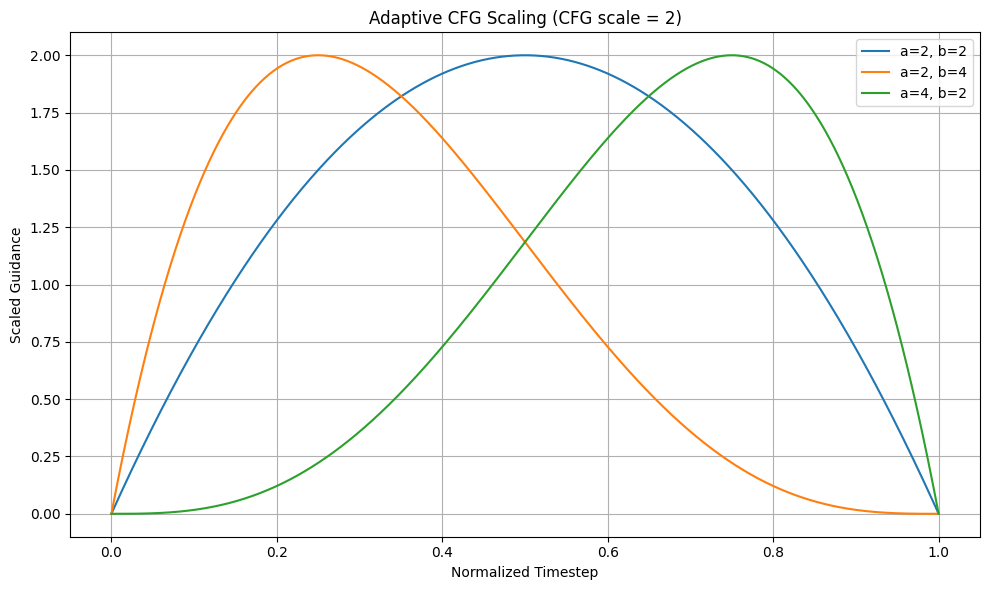

In [49]:
from scipy.stats import beta

# Define the x-axis range
x = np.linspace(0, 1, 1000)
cfg_scale = 2

# Compute beta distribution PDFs
pdf1 = beta.pdf(x, a=2, b=2)
pdf2 = beta.pdf(x, a=2, b=4)
pdf3 = beta.pdf(x, a=4, b=2)

# Scale each PDF so that the maximum value is equal to cfg_scale
pdf1_scaled = cfg_scale * pdf1 / np.max(pdf1)
pdf2_scaled = cfg_scale * pdf2 / np.max(pdf2)
pdf3_scaled = cfg_scale * pdf3 / np.max(pdf3)

# Plot the scaled beta distributions
plt.figure(figsize=(10, 6))
plt.plot(x, pdf1_scaled, label='a=2, b=2')
plt.plot(x, pdf2_scaled, label='a=2, b=4')
plt.plot(x, pdf3_scaled, label='a=4, b=2')
plt.title("Adaptive CFG Scaling (CFG scale = 2)")
plt.xlabel("Normalized Timestep")
plt.ylabel("Scaled Guidance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Noise steps

In [29]:
model_info = {
    "10": "predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg2_ns10.csv",
    "20": "predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg2_ns20.csv",
    "30": "predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg2.csv",
}

epoch = 40
metrics_dict = {}

for model_name, path_name in model_info.items():
    df = pd.read_csv(path_name)
    x_real = np.array([str_to_float_list(row) for row in df['x_real']])
    predictions = np.array([str_to_float_list(row) for row in df['predictions']])
    print(model_name)
    mse, _, wasserstein, _, dtw, _ = calculate_metrics(x_real, predictions, print_results=False)

    metrics_dict[model_name] = {
        "mse": mse,
        "wasserstein": wasserstein,
        "dtw": dtw
    }

10
20
30



📋 Summary of Mean and Median for Each Metric:

📊 MSE:
  10         | Mean: 2436.7789 | Median: 2058.7705
  20         | Mean: 2312.6903 | Median: 2063.2641
  30         | Mean: 2265.9260 | Median: 2051.3189

📊 Wasserstein Distance:
  10         | Mean: 16.5383 | Median: 5.9393
  20         | Mean: 16.6765 | Median: 5.5884
  30         | Mean: 16.6679 | Median: 5.6081

📊 DTW Distance:
  10         | Mean: 10221.8310 | Median: 9919.1046
  20         | Mean: 9725.6805 | Median: 9563.7731
  30         | Mean: 9658.3816 | Median: 9581.0276



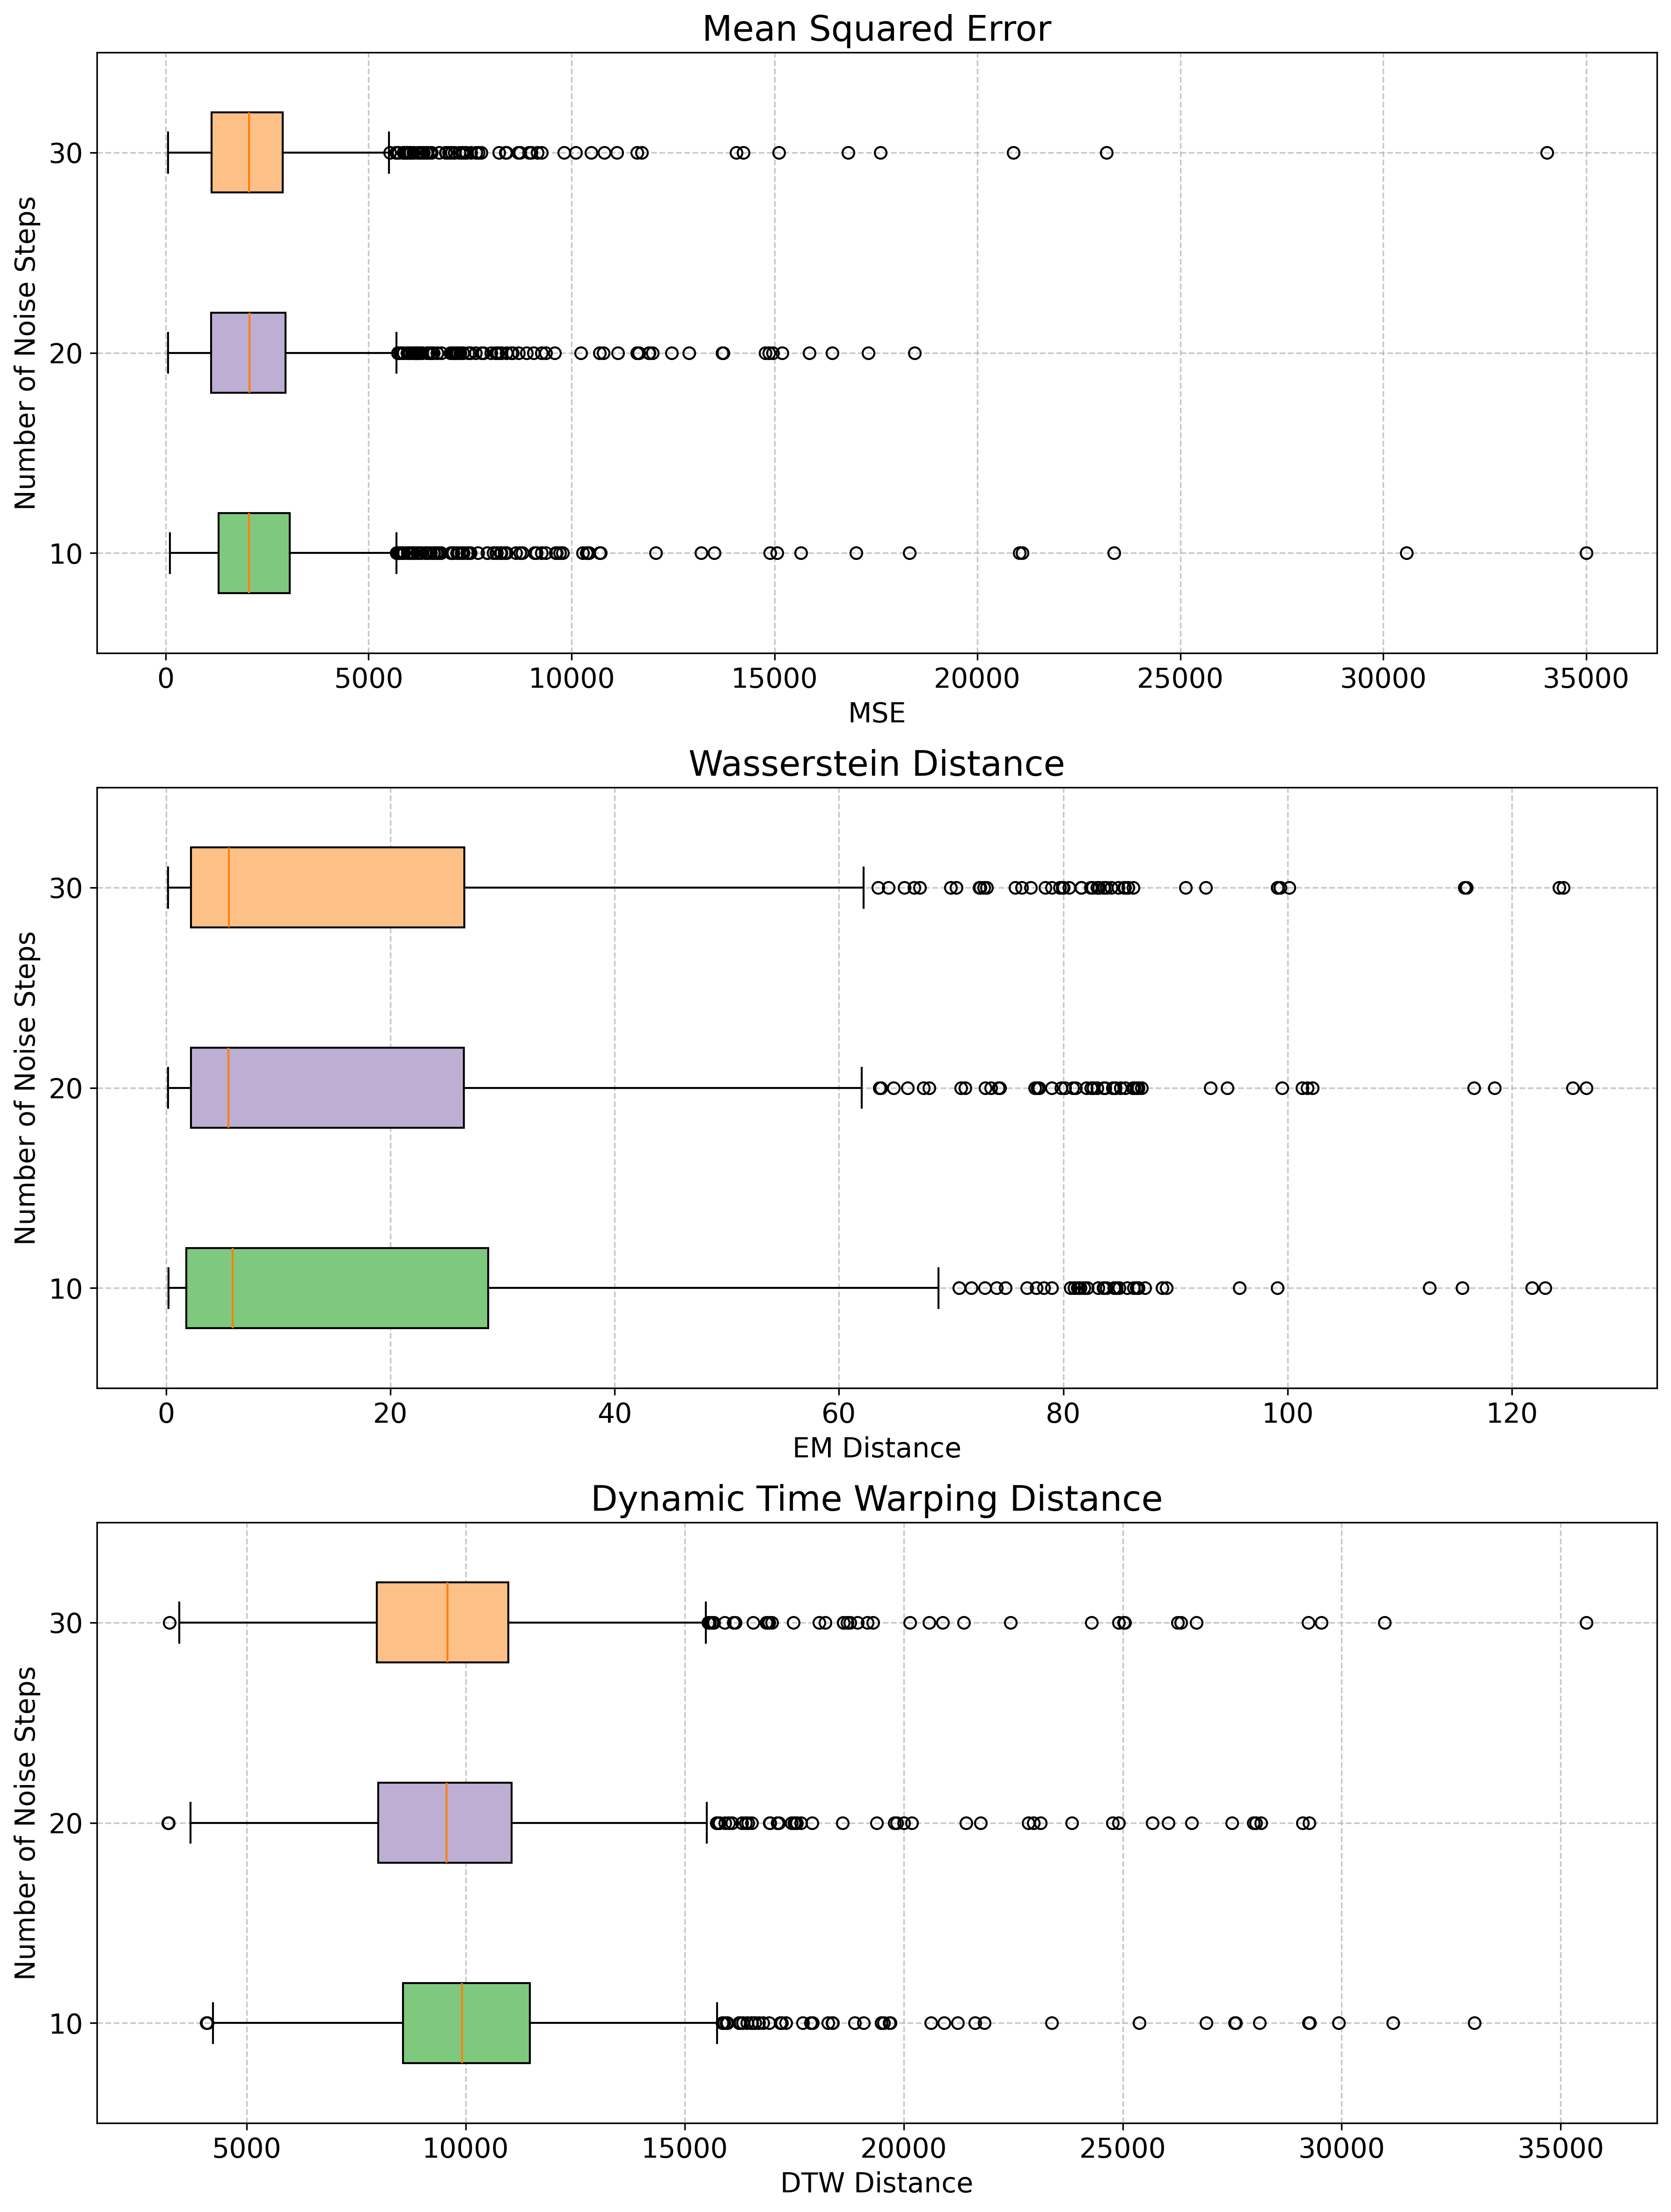

In [30]:
print_metric_summary(metrics_dict)

plot_combined_metrics_boxplots(metrics_dict, ylabel="Number of Noise Steps")

## DDIM

In [33]:
model_info = {
    "0 %": {"path": "ddim_bs16_do0_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999", "cfg_scale": 3},
    "10 %": {"path": "ddim_bs16_do10_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999", "cfg_scale": 3},
    "20 %": {"path": "ddim_bs16_do20_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999", "cfg_scale": 3},
}

epoch = 40
metrics_dict = {}

for model_display_name, model_config in model_info.items():
    path_name = model_config["path"]
    cfg_scale = model_config.get("cfg_scale", None)

    x_real, predictions = load_predictions_for_model(path_name, epoch, cfg_scale)
    print(model_display_name)
    mse, _, wasserstein, _, dtw, _ = calculate_metrics(x_real, predictions, print_results=False)

    metrics_dict[model_display_name] = {
        "mse": mse,
        "wasserstein": wasserstein,
        "dtw": dtw
    }

predictions/ddim_bs16_do0_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999/preds_epoch40_cfg3.csv
0 %
predictions/ddim_bs16_do10_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999/preds_epoch40_cfg3.csv
10 %
predictions/ddim_bs16_do20_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999/preds_epoch40_cfg3.csv
20 %



📋 Summary of Mean and Median for Each Metric:

📊 MSE:
  0 %        | Mean: 5948.0809 | Median: 3120.3056
  10 %       | Mean: 5106.8182 | Median: 2964.0436
  20 %       | Mean: 5844.7530 | Median: 4254.3694

📊 Wasserstein Distance:
  0 %        | Mean: 26.7615 | Median: 7.5255
  10 %       | Mean: 25.3470 | Median: 7.6834
  20 %       | Mean: 31.6927 | Median: 7.8104

📊 DTW Distance:
  0 %        | Mean: 15516.5142 | Median: 12557.6128
  10 %       | Mean: 14719.3611 | Median: 12448.8579
  20 %       | Mean: 16996.4986 | Median: 15435.2687



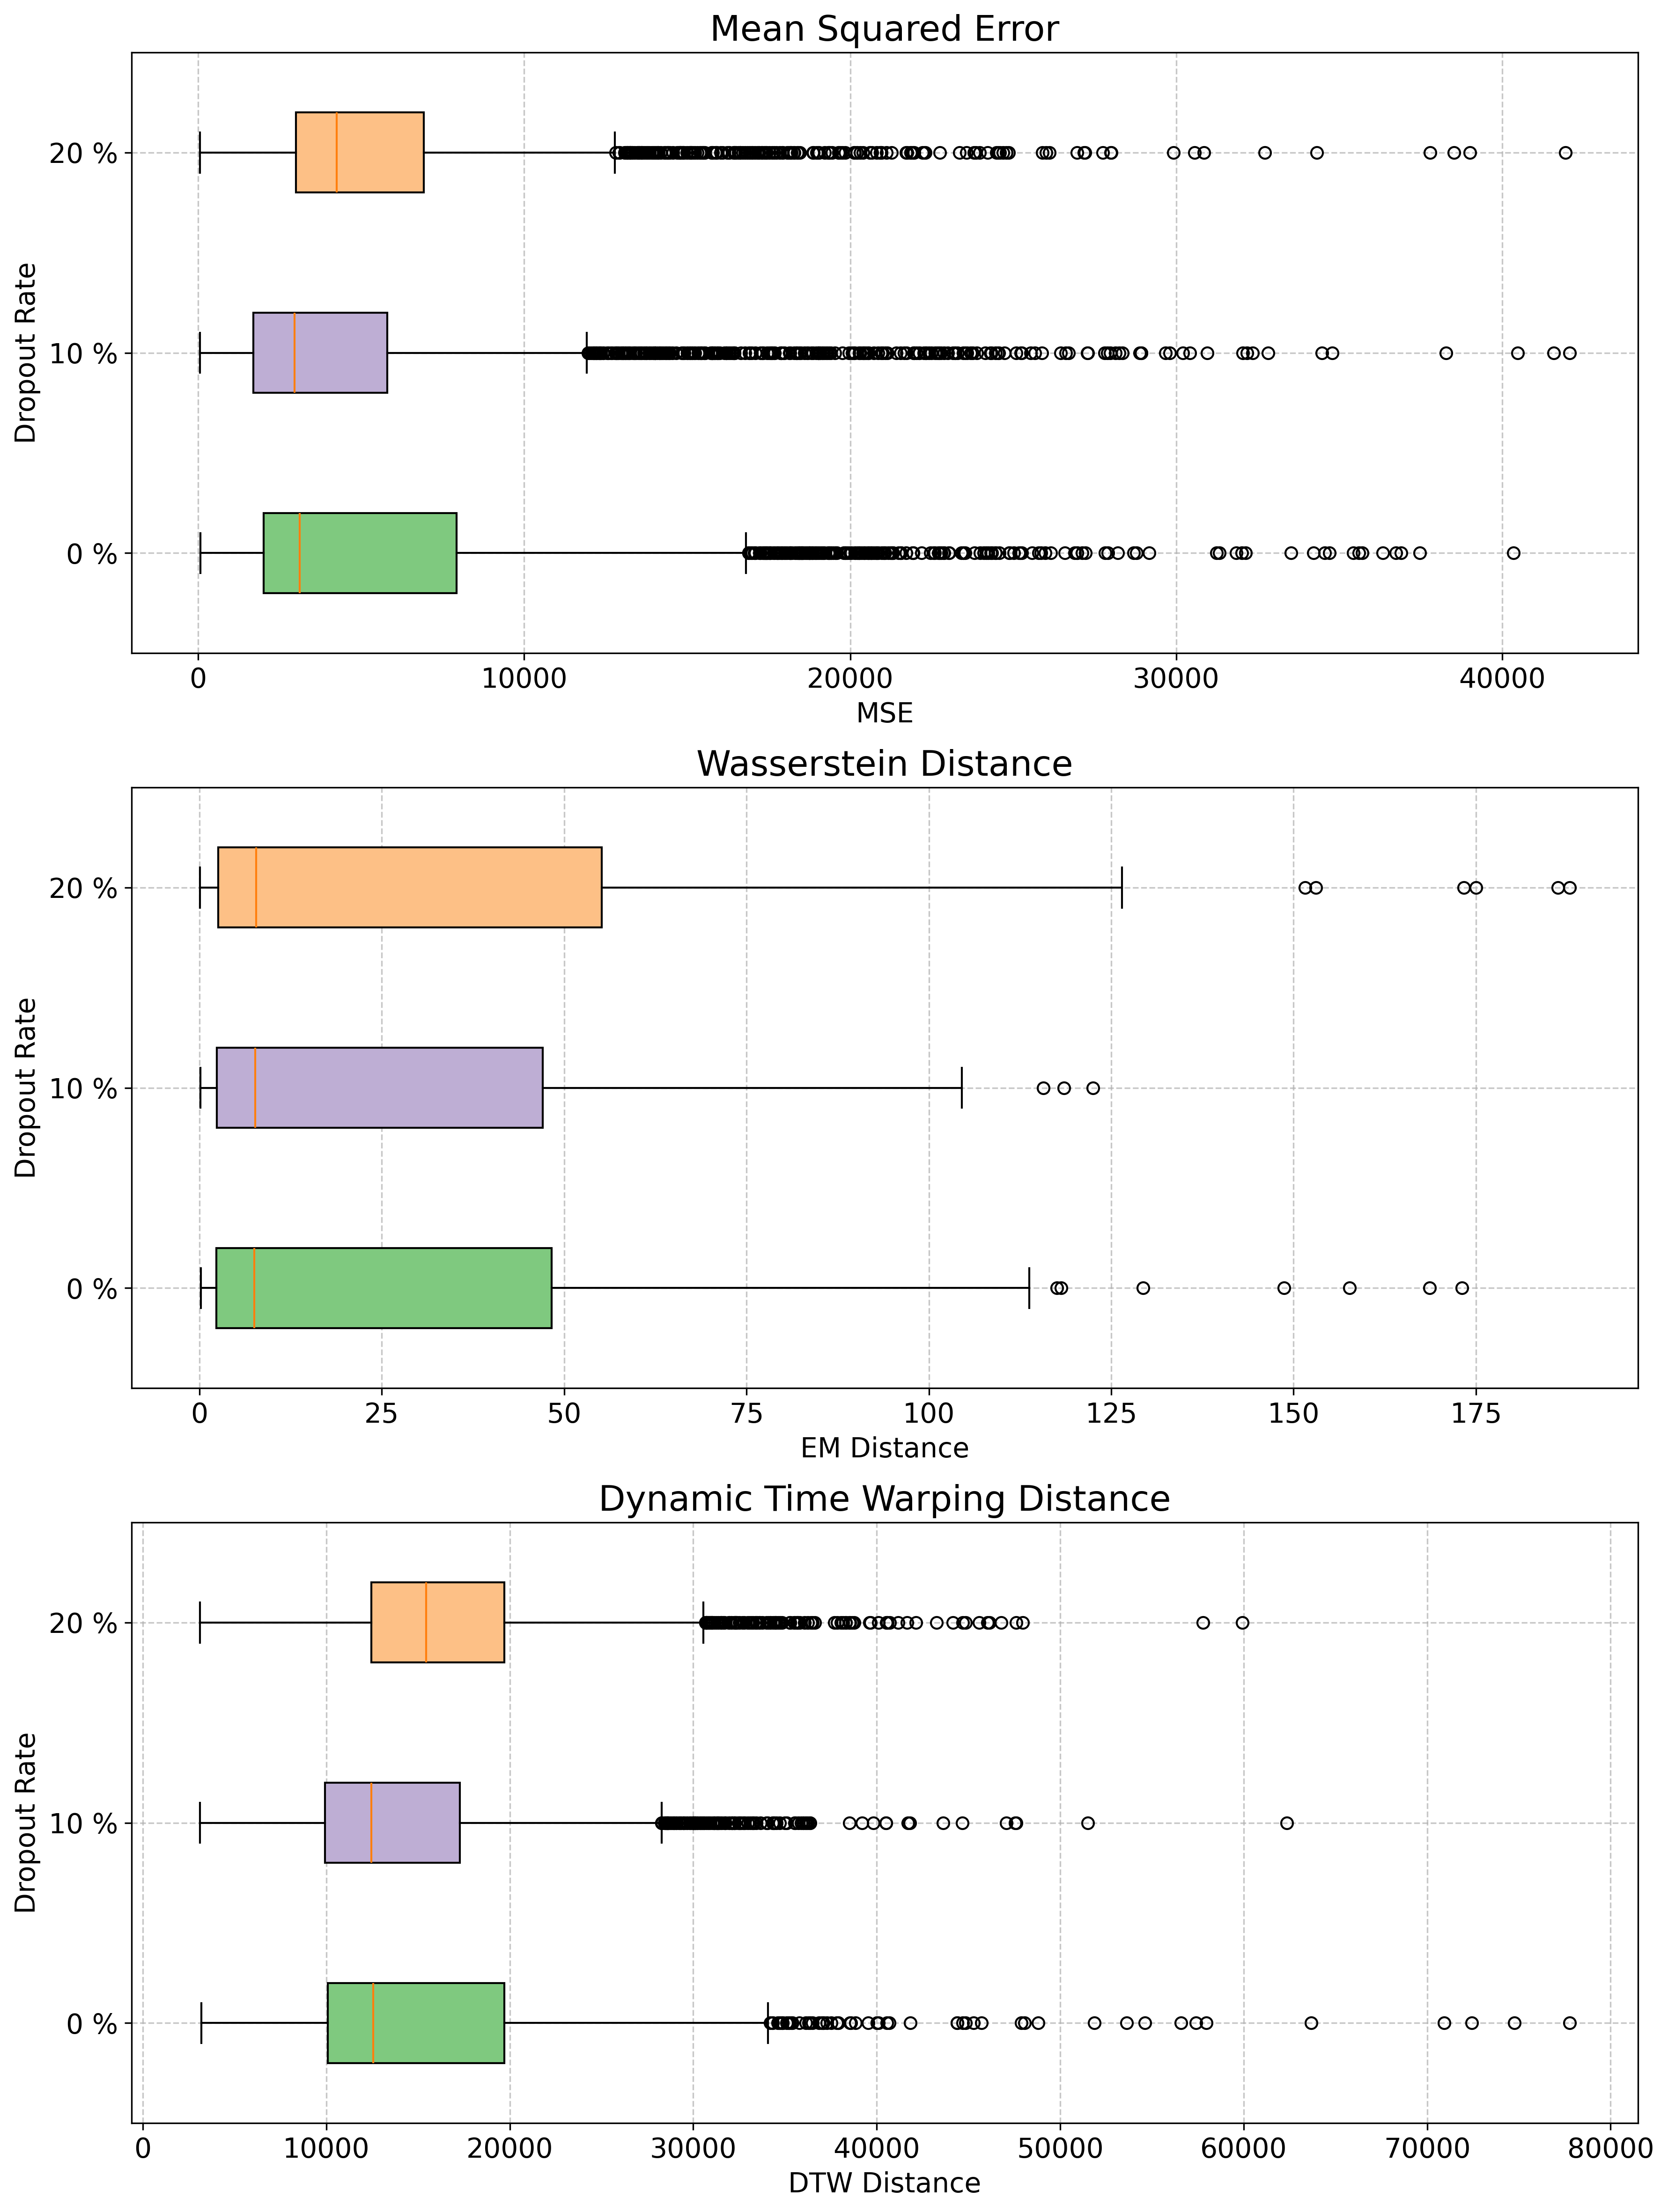

In [35]:
print_metric_summary(metrics_dict)

plot_combined_metrics_boxplots(metrics_dict, ylabel="Dropout Rate")

### CFG scales

In [31]:
model_info = {
    "no cfg": {"path": "ddim_bs16_do10_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999", "cfg_scale": 0},
    "1": {"path": "ddim_bs16_do10_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999", "cfg_scale": 1},
    "2": {"path": "ddim_bs16_do10_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999", "cfg_scale": 2},
    "3": {"path": "ddim_bs16_do10_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999", "cfg_scale": 3},
    "4": {"path": "ddim_bs16_do10_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999", "cfg_scale": 4},
}

epoch = 40
metrics_dict = {}

for model_display_name, model_config in model_info.items():
    path_name = model_config["path"]
    cfg_scale = model_config.get("cfg_scale", None)

    x_real, predictions = load_predictions_for_model(path_name, epoch, cfg_scale)
    print(model_display_name)
    mse, _, wasserstein, _, dtw, _ = calculate_metrics(x_real, predictions, print_results=False)

    metrics_dict[model_display_name] = {
        "mse": mse,
        "wasserstein": wasserstein,
        "dtw": dtw
    }

predictions/ddim_bs16_do10_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999/preds_epoch40_cfg0.csv
no cfg
predictions/ddim_bs16_do10_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999/preds_epoch40_cfg1.csv
1
predictions/ddim_bs16_do10_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999/preds_epoch40_cfg2.csv
2
predictions/ddim_bs16_do10_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999/preds_epoch40_cfg3.csv
3
predictions/ddim_bs16_do10_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999/preds_epoch40_cfg4.csv
4



📋 Summary of Mean and Median for Each Metric:

📊 MSE:
  no cfg     | Mean: 4603.2315 | Median: 3152.9186
  1          | Mean: 4474.0558 | Median: 3107.8594
  2          | Mean: 4769.0899 | Median: 3002.0968
  3          | Mean: 5106.8182 | Median: 2964.0436
  4          | Mean: 4752.6701 | Median: 3349.2793

📊 Wasserstein Distance:
  no cfg     | Mean: 24.8909 | Median: 7.9353
  1          | Mean: 24.8722 | Median: 7.9265
  2          | Mean: 24.9219 | Median: 7.7958
  3          | Mean: 25.3470 | Median: 7.6834
  4          | Mean: 25.8618 | Median: 7.9322

📊 DTW Distance:
  no cfg     | Mean: 14808.3910 | Median: 13023.8721
  1          | Mean: 14547.5368 | Median: 13039.4139
  2          | Mean: 14511.2497 | Median: 12694.7672
  3          | Mean: 14719.3611 | Median: 12448.8579
  4          | Mean: 15089.3038 | Median: 13278.9042



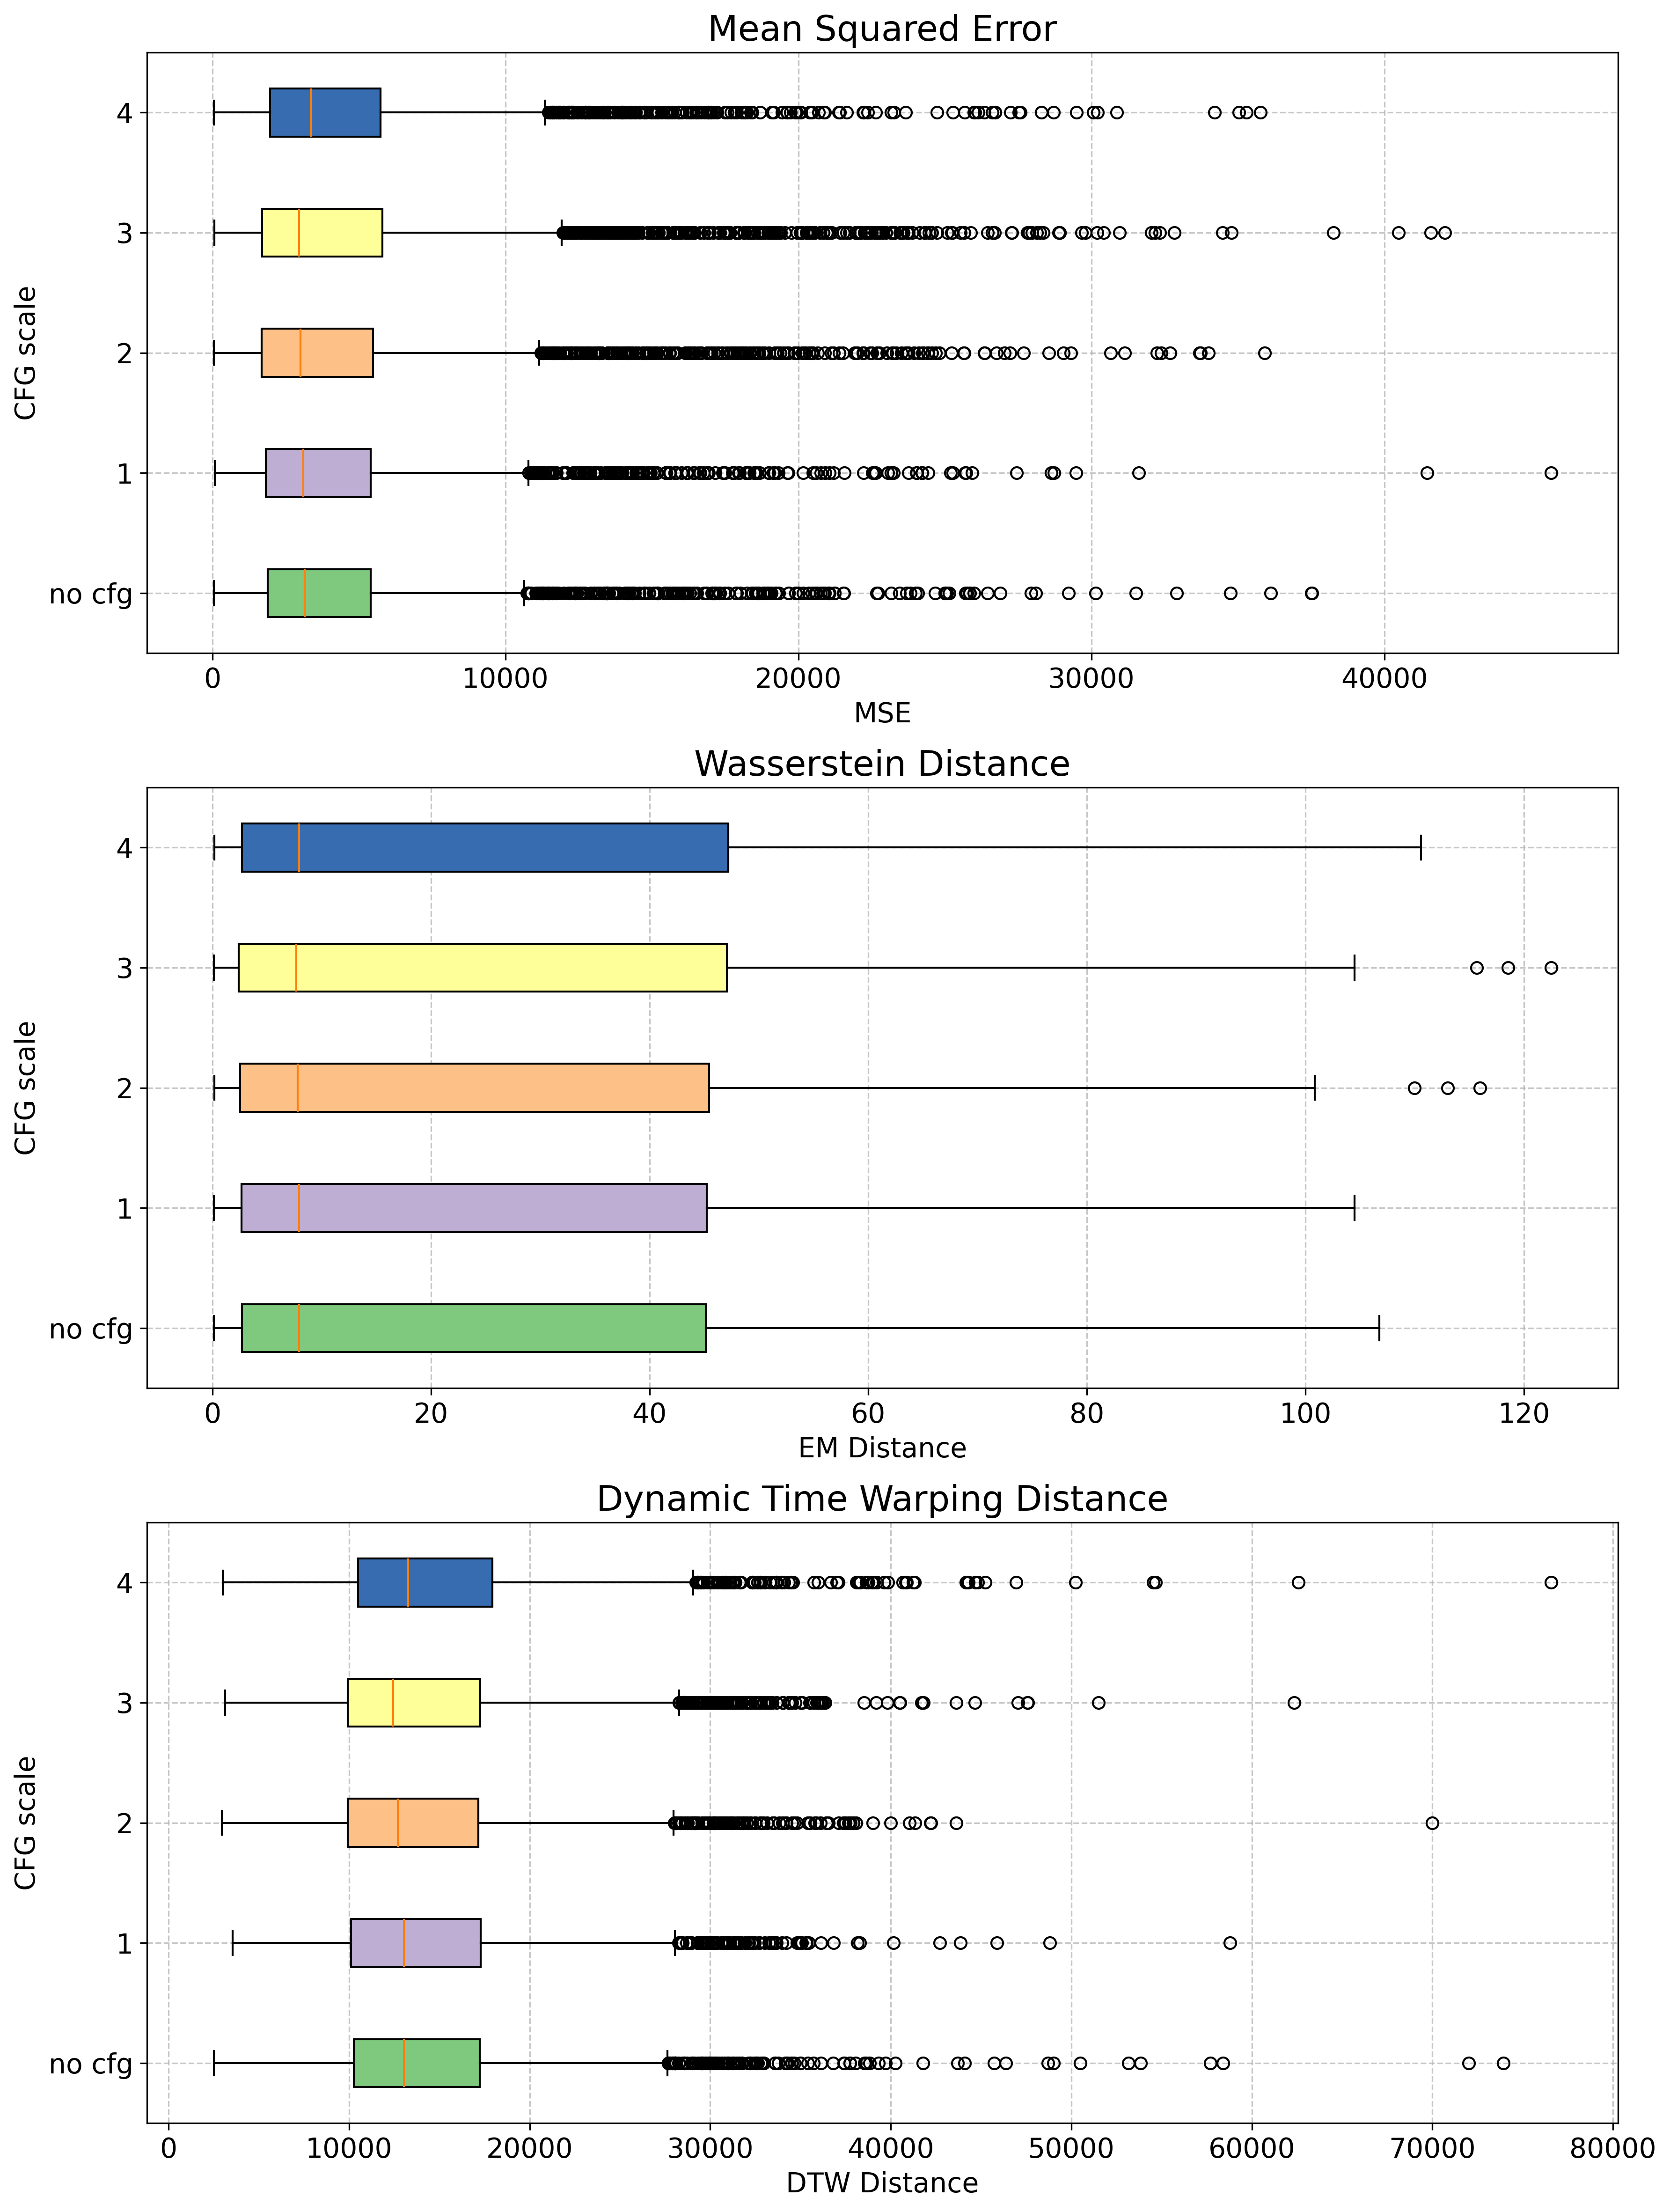

In [32]:
print_metric_summary(metrics_dict)

plot_combined_metrics_boxplots(metrics_dict, ylabel="CFG scale")

### Section counts

20
40
60

📋 Summary of Mean and Median for Each Metric:

📊 MSE:
  20         | Mean: 4606.2929 | Median: 2864.5369
  40         | Mean: 4769.0899 | Median: 3002.0968
  60         | Mean: 4883.9026 | Median: 3033.5307

📊 Wasserstein Distance:
  20         | Mean: 24.4144 | Median: 7.6412
  40         | Mean: 24.9219 | Median: 7.7958
  60         | Mean: 25.9593 | Median: 7.8554

📊 DTW Distance:
  20         | Mean: 14291.1007 | Median: 12371.8629
  40         | Mean: 14511.2497 | Median: 12694.7672
  60         | Mean: 14780.6977 | Median: 12812.4608



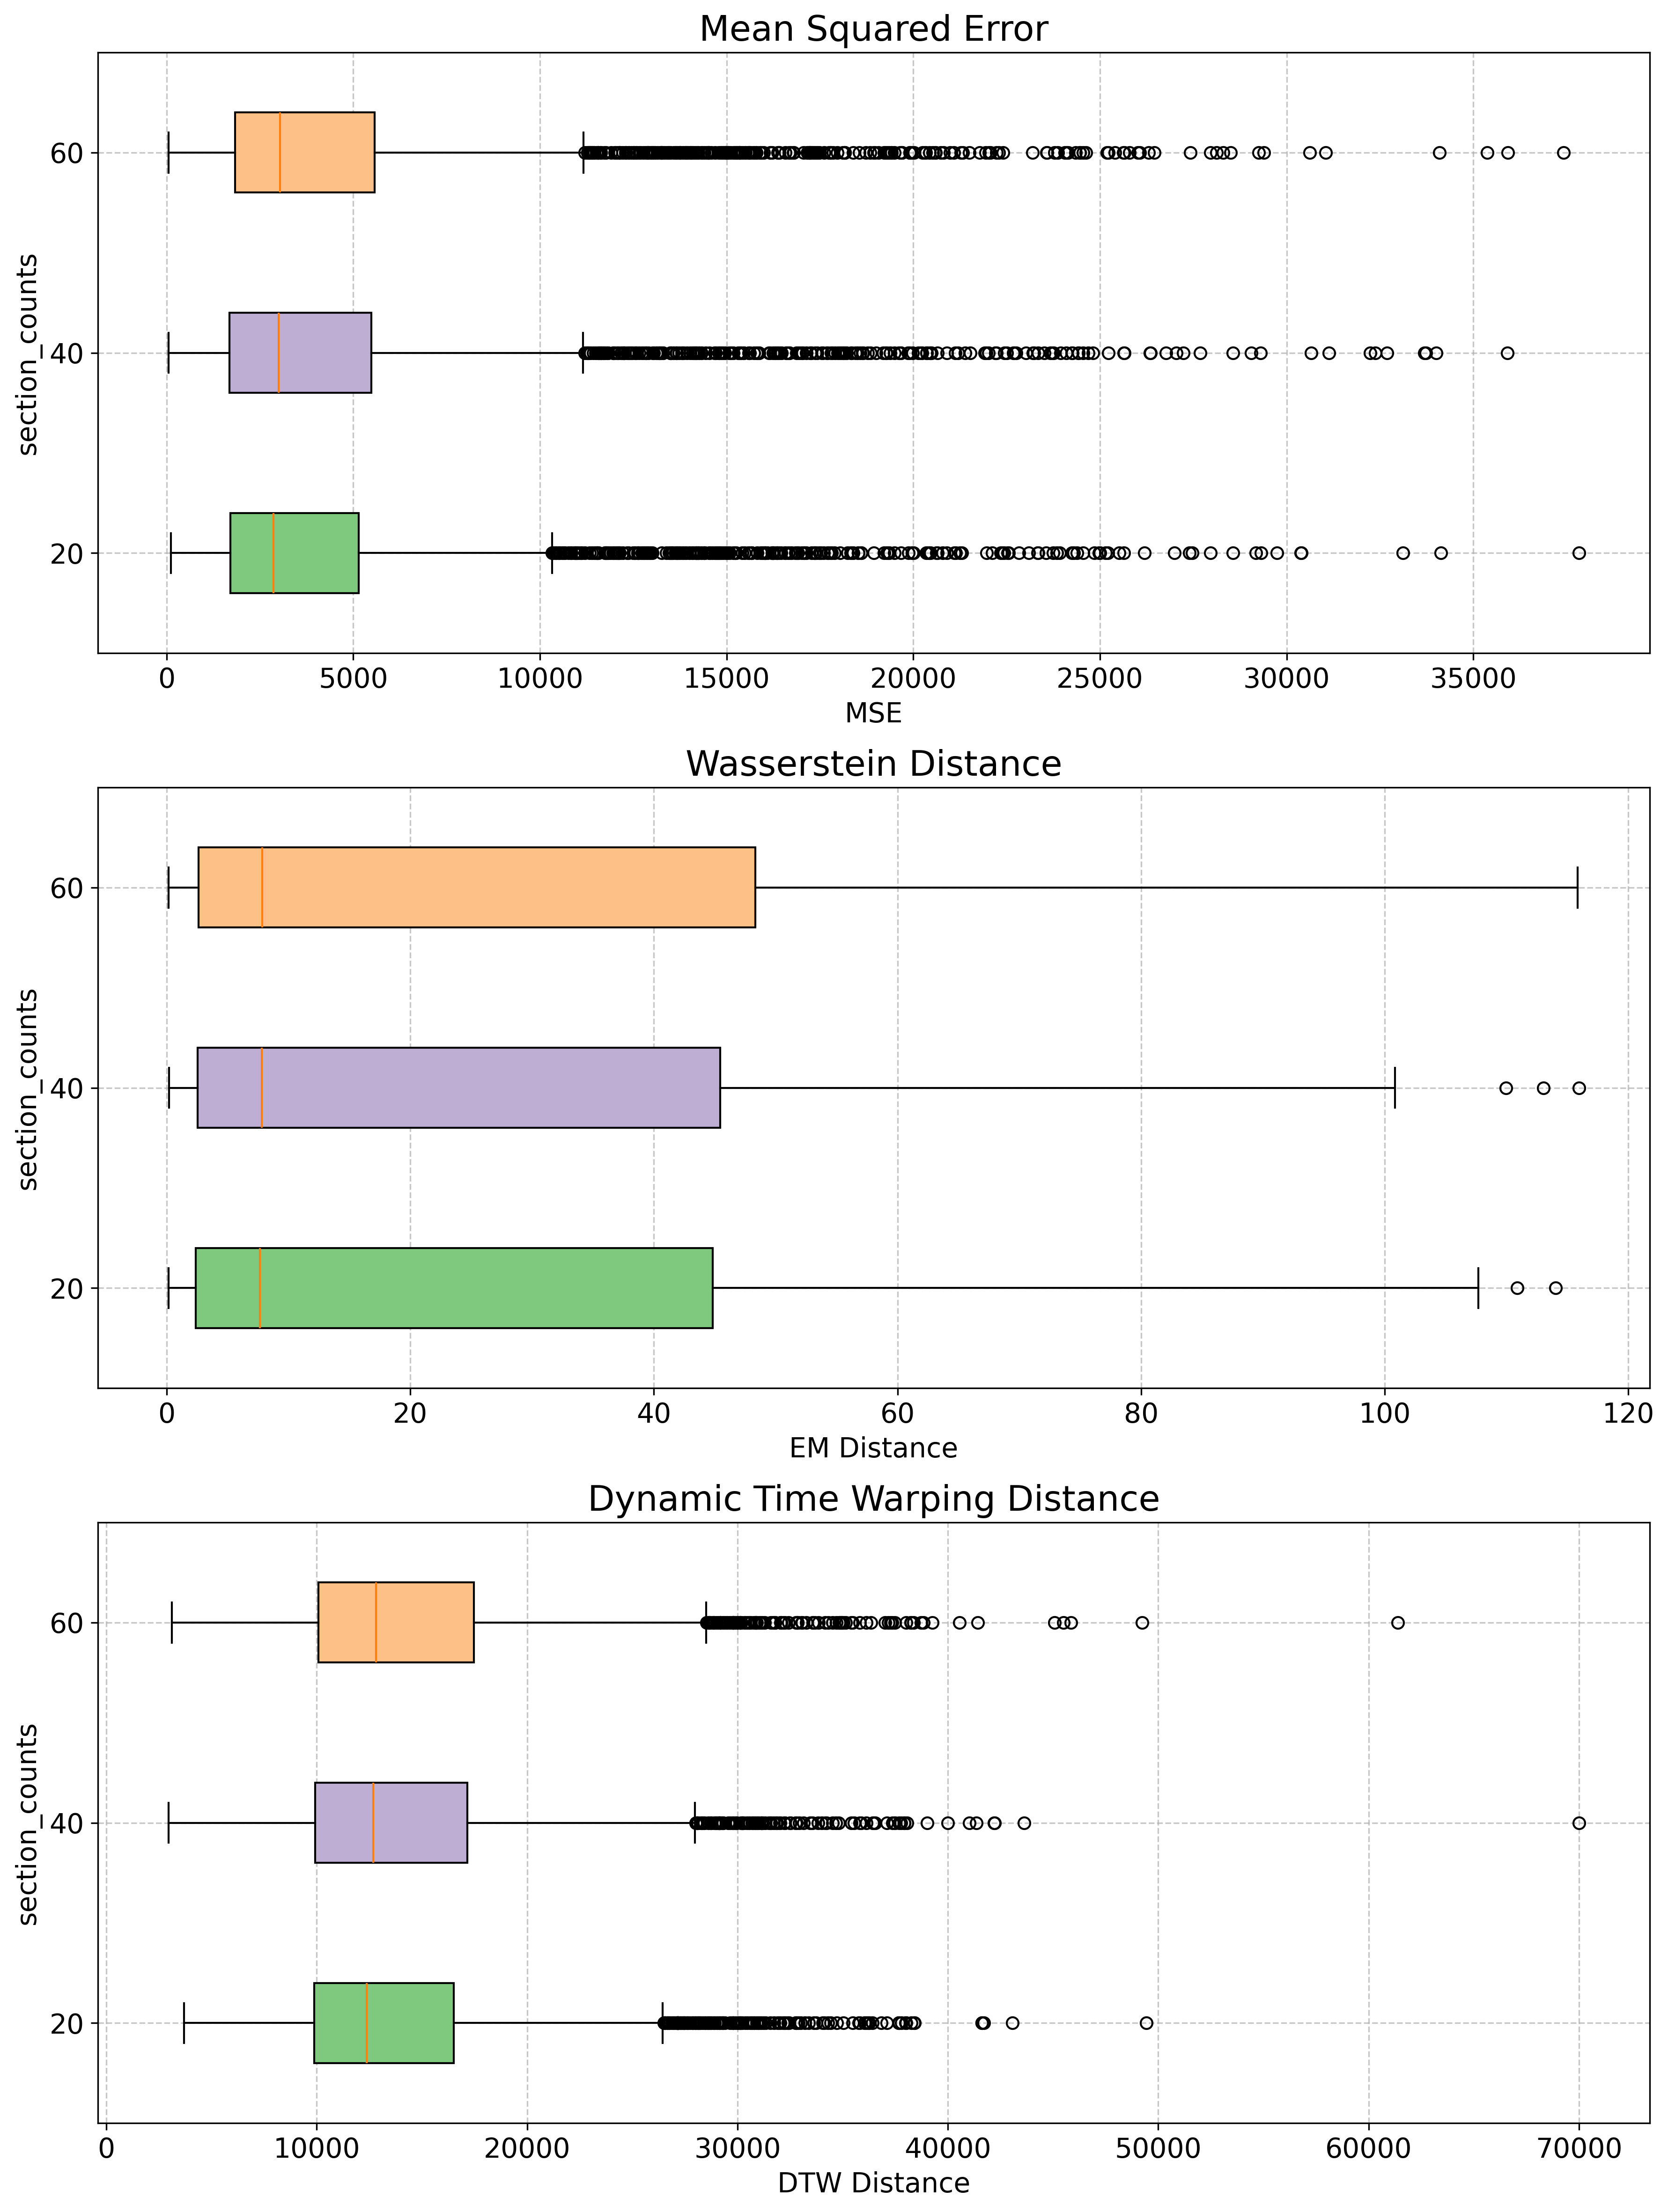

In [36]:
model_info = {
    "20": "predictions/ddim_bs16_do10_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999/preds_epoch40_cfg2_sc20.csv",
    "40": "predictions/ddim_bs16_do10_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999/preds_epoch40_cfg2.csv",
    "60": "predictions/ddim_bs16_do10_cgt10_cg3_ns1000_sc20_lr1e-3_0_e40_ed999/preds_epoch40_cfg2_sc60.csv",
}

epoch = 40
metrics_dict = {}

for model_name, path_name in model_info.items():
    df = pd.read_csv(path_name)
    x_real = np.array([str_to_float_list(row) for row in df['x_real']])
    predictions = np.array([str_to_float_list(row) for row in df['predictions']])
    print(model_name)
    mse, _, wasserstein, _, dtw, _ = calculate_metrics(x_real, predictions, print_results=False)

    metrics_dict[model_name] = {
        "mse": mse,
        "wasserstein": wasserstein,
        "dtw": dtw
    }

print_metric_summary(metrics_dict)

plot_combined_metrics_boxplots(metrics_dict, ylabel="section_counts")

## Final model

In [50]:
model_info = {
    "": "predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg2_test_data.csv",
}

epoch = 40
metrics_dict = {}

for model_name, path_name in model_info.items():
    df = pd.read_csv(path_name)
    x_real = np.array([str_to_float_list(row) for row in df['x_real']])
    predictions = np.array([str_to_float_list(row) for row in df['predictions']])
    print(model_name)
    mse, _, wasserstein, _, dtw, _ = calculate_metrics(x_real, predictions, print_results=False)

    metrics_dict[model_name] = {
        "mse": mse,
        "wasserstein": wasserstein,
        "dtw": dtw
    }


📋 Summary of Mean and Median for Each Metric:

📊 MSE:
             | Mean: 2612.6711 | Median: 2502.1999

📊 Wasserstein Distance:
             | Mean: 20.9018 | Median: 6.5470

📊 DTW Distance:
             | Mean: 9504.9354 | Median: 9403.8619



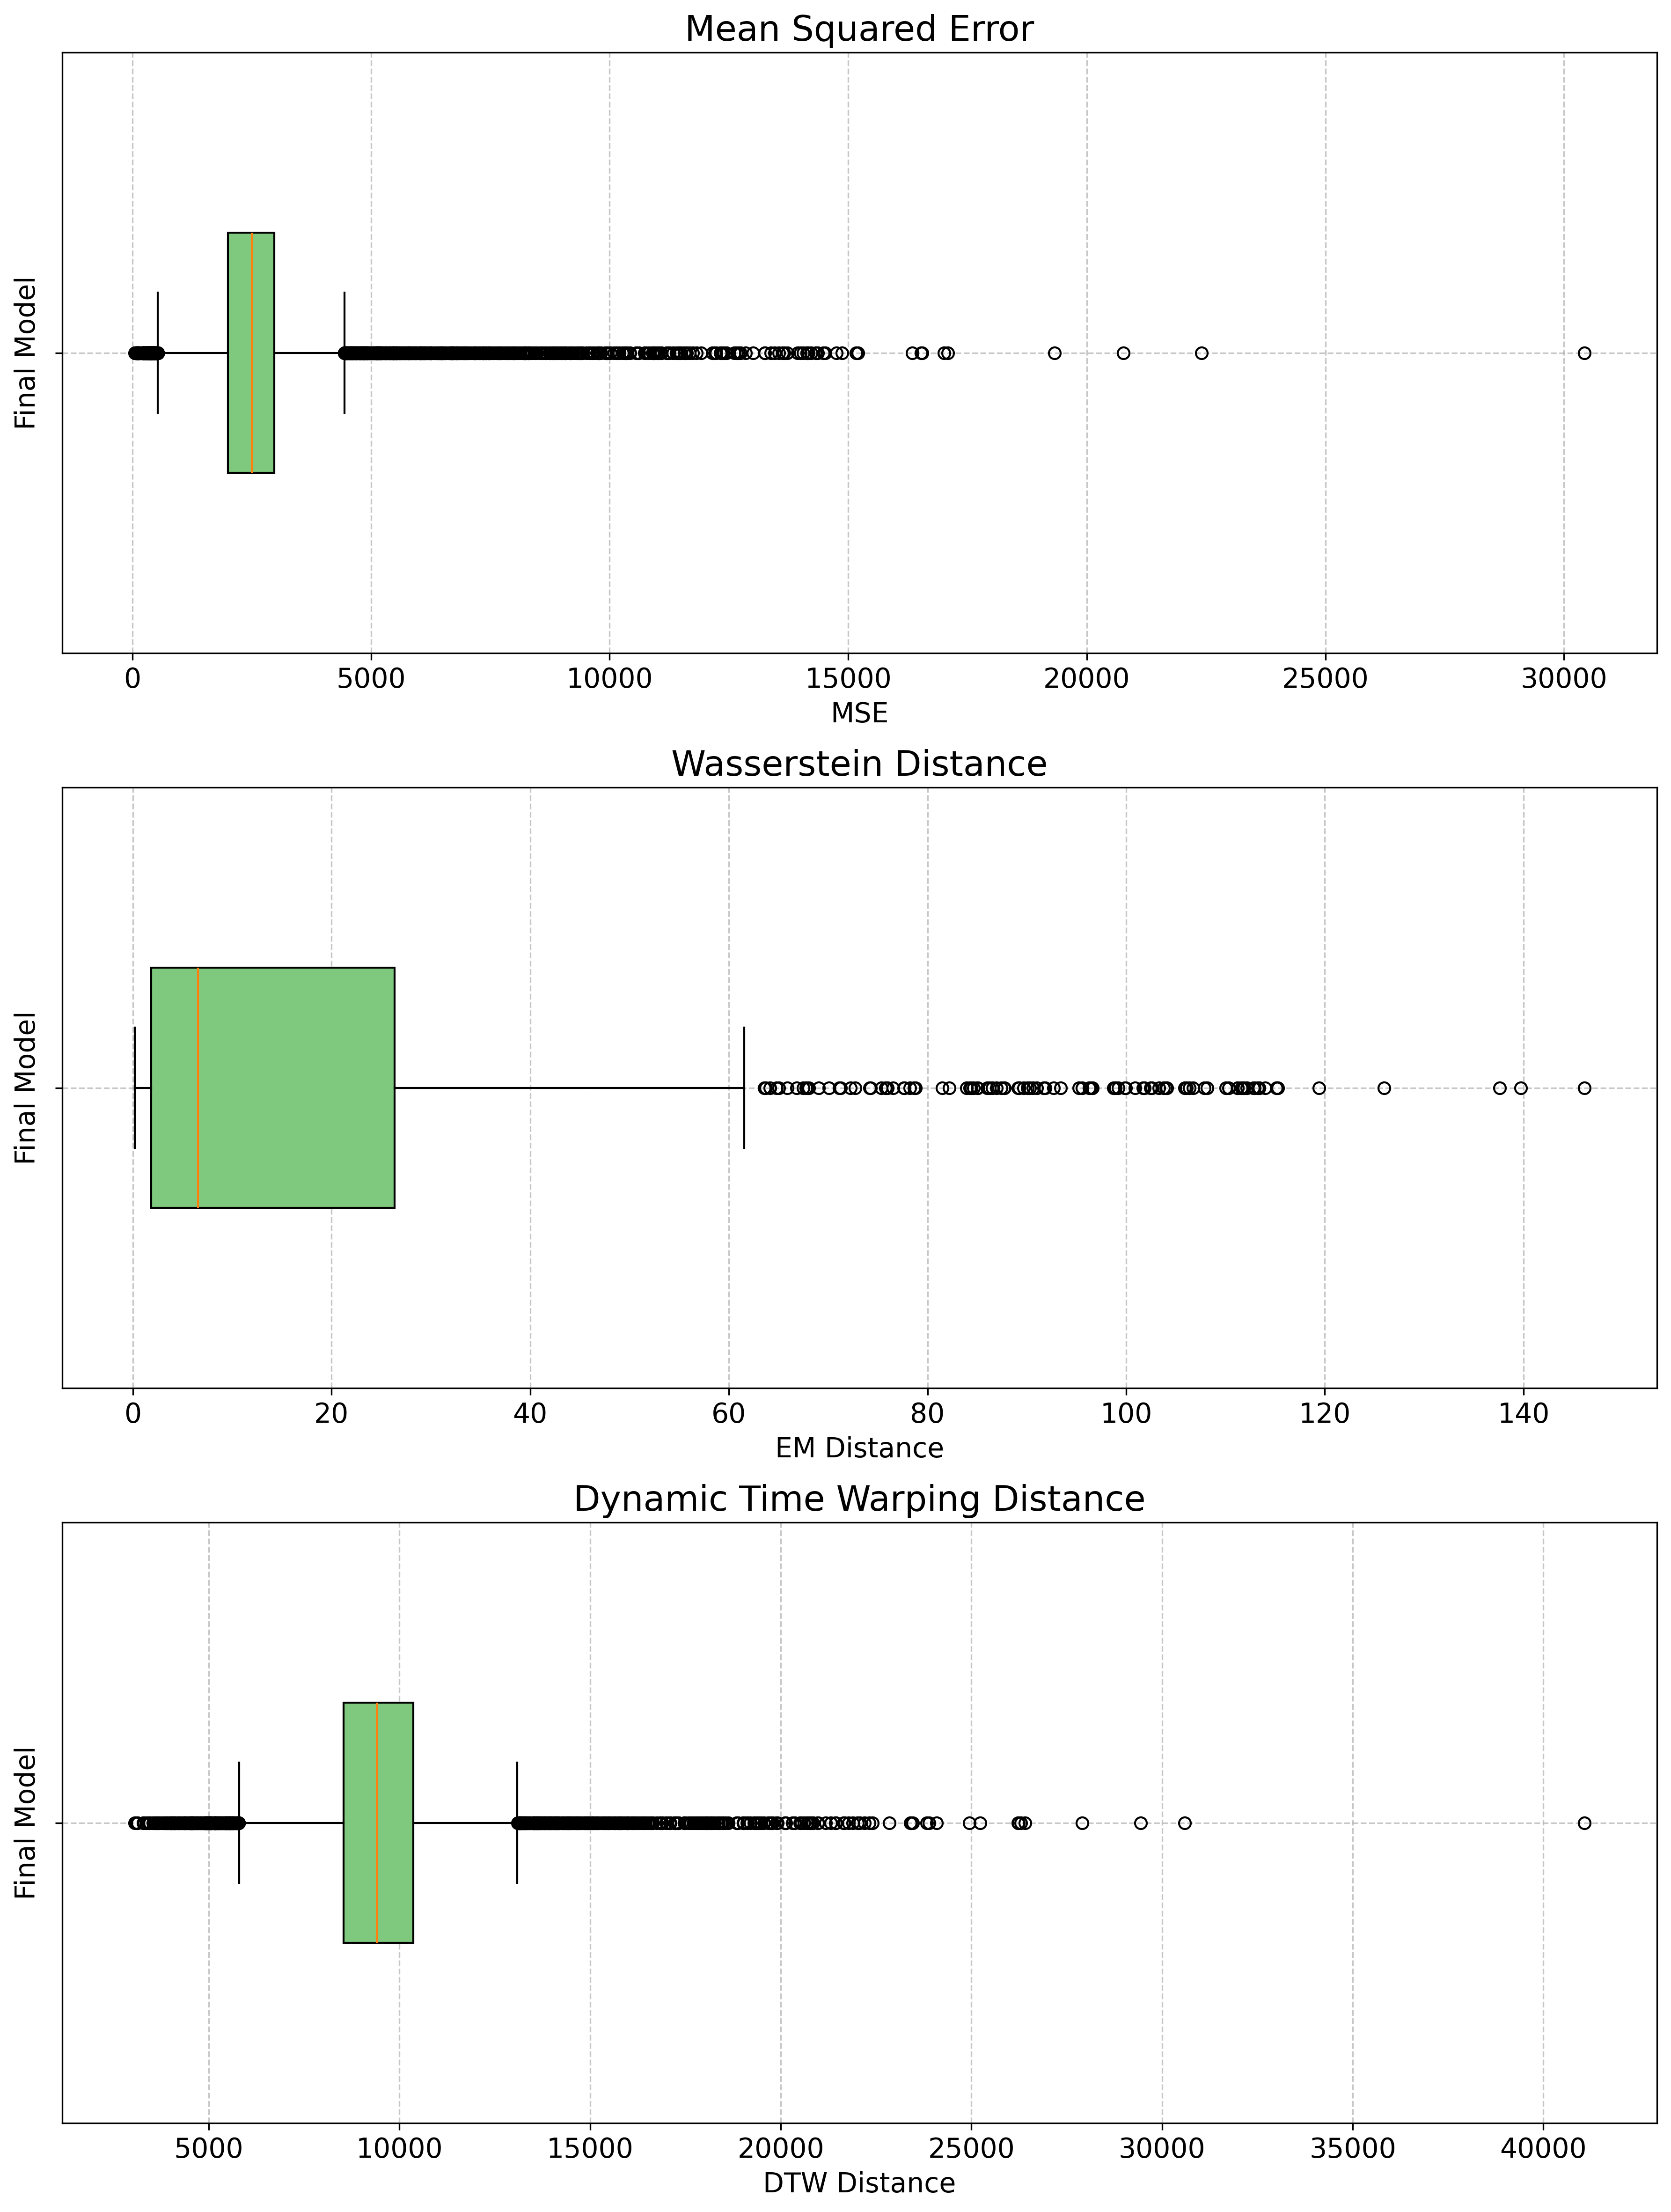

In [51]:
print_metric_summary(metrics_dict)

plot_combined_metrics_boxplots(metrics_dict, ylabel="Final Model")

In [52]:
model_info = {
    "test data": "predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg2_test_data.csv",
    "validation data": "predictions/edm_bs16_do0_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/preds_epoch40_cfg2.csv",
}

epoch = 40
metrics_dict = {}

for model_name, path_name in model_info.items():
    df = pd.read_csv(path_name)
    x_real = np.array([str_to_float_list(row) for row in df['x_real']])
    predictions = np.array([str_to_float_list(row) for row in df['predictions']])
    print(model_name)
    mse, _, wasserstein, _, dtw, _ = calculate_metrics(x_real, predictions, print_results=False)

    metrics_dict[model_name] = {
        "mse": mse,
        "wasserstein": wasserstein,
        "dtw": dtw
    }

test data
validation data



📋 Summary of Mean and Median for Each Metric:

📊 MSE:
  test data  | Mean: 2612.6711 | Median: 2502.1999
  validation data | Mean: 2265.9260 | Median: 2051.3189

📊 Wasserstein Distance:
  test data  | Mean: 20.9018 | Median: 6.5470
  validation data | Mean: 16.6679 | Median: 5.6081

📊 DTW Distance:
  test data  | Mean: 9504.9354 | Median: 9403.8619
  validation data | Mean: 9658.3816 | Median: 9581.0276



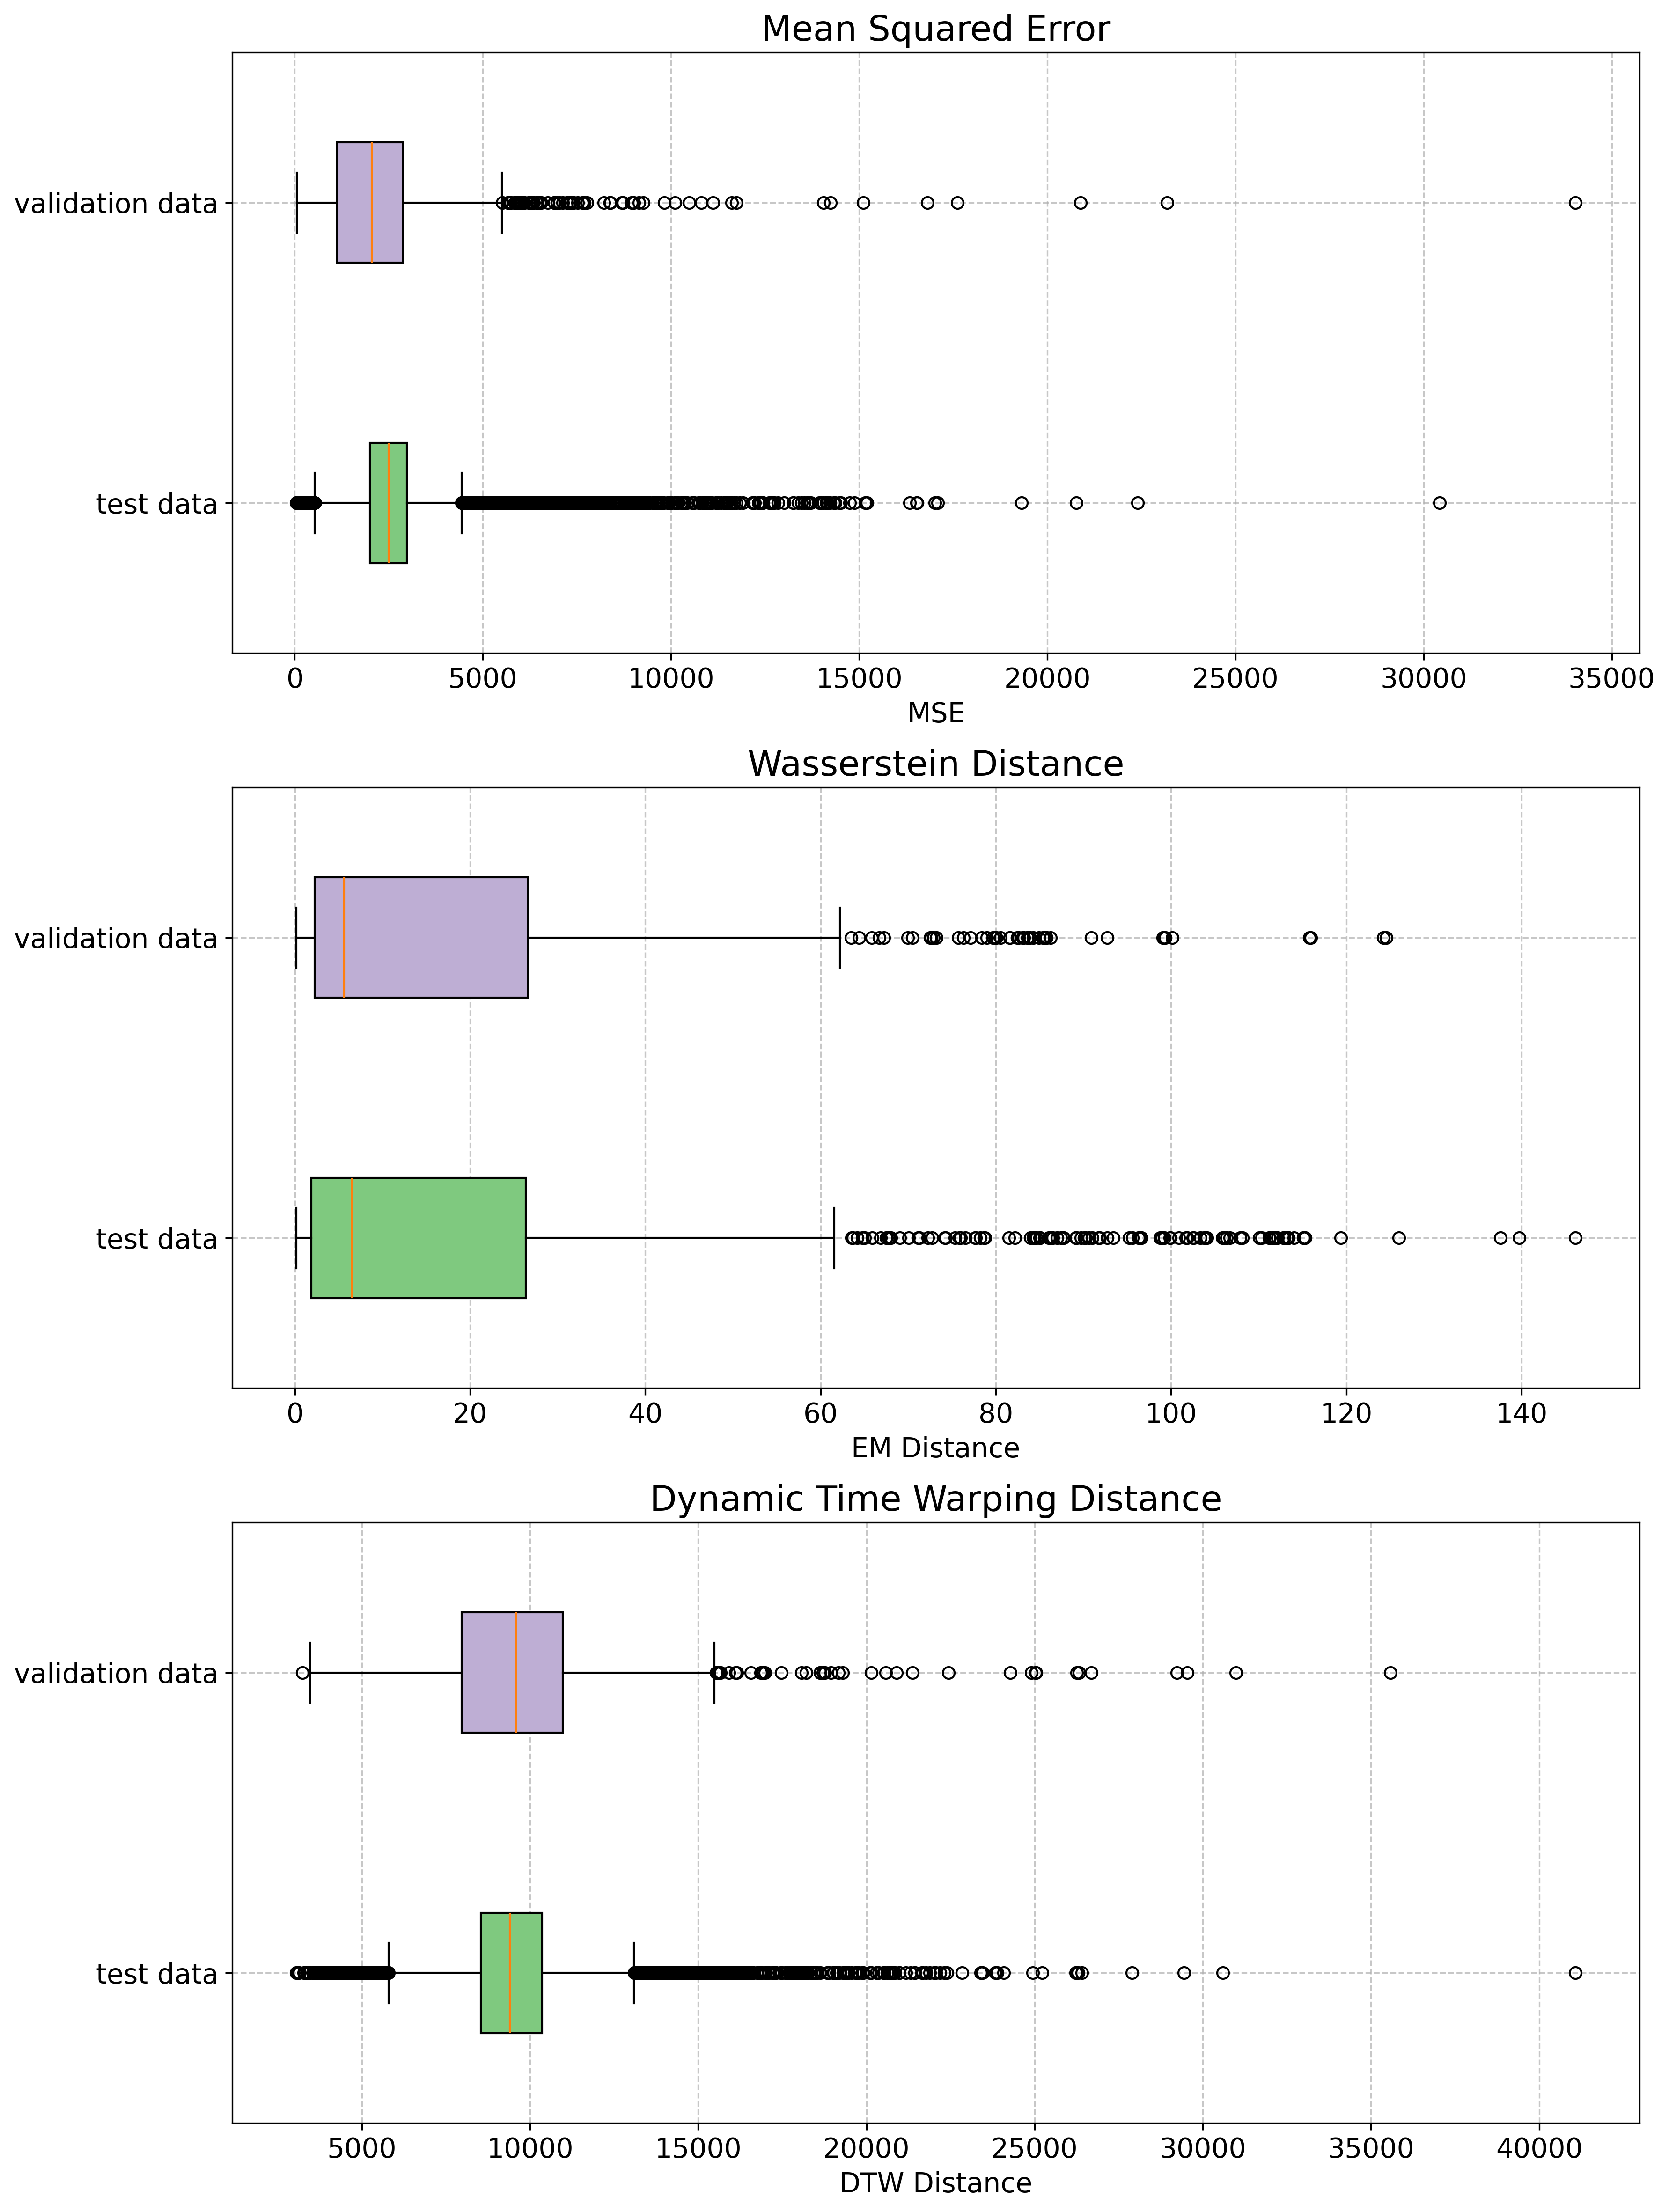

In [53]:
print_metric_summary(metrics_dict)

plot_combined_metrics_boxplots(metrics_dict, ylabel="")